# EMPIRICAL DATA ANALYSIS

In questa sezione sono raccolte analisi preliminari su Industrial Production (IP) complessiva di UE27 (indice IPI preso da Eurostat, 2015 = 100) e Gas Price (GP). 

Più precisamente, ho fatto:
- Plot delle medie e varianze
- Seasonal decomposition
- Analisi delle distribuzioni e test della normalità
- Test di correlazione
- Test di cointegrazione
- Test per la presenza di structural break
- Stima di un modello ARIMA per IP

In [ ]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
#import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib as mpl
from scipy import stats
from utils import plot_series, plot_rolling_variance, plot_rolling_mean, plot_decomposition, analyze_order, find_best_model, ljung_box_test, analyze_cointegration, fit_arima_models, johansen_test_manual, engle_granger_test_manual
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import warnings
from chow_test import chow_test


In [2]:
os.chdir('C:\\Users\\loren\\OneDrive\\Desktop\\PhD\\Progetto\\python\\')
path = 'data'

In [3]:
df = pd.read_csv(os.path.join(path, "sample_df.csv"))

In [4]:
df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m")

df = df.rename(columns={"OBS_VALUE": "IP"})

In [5]:
df.set_index('Time', inplace=True)

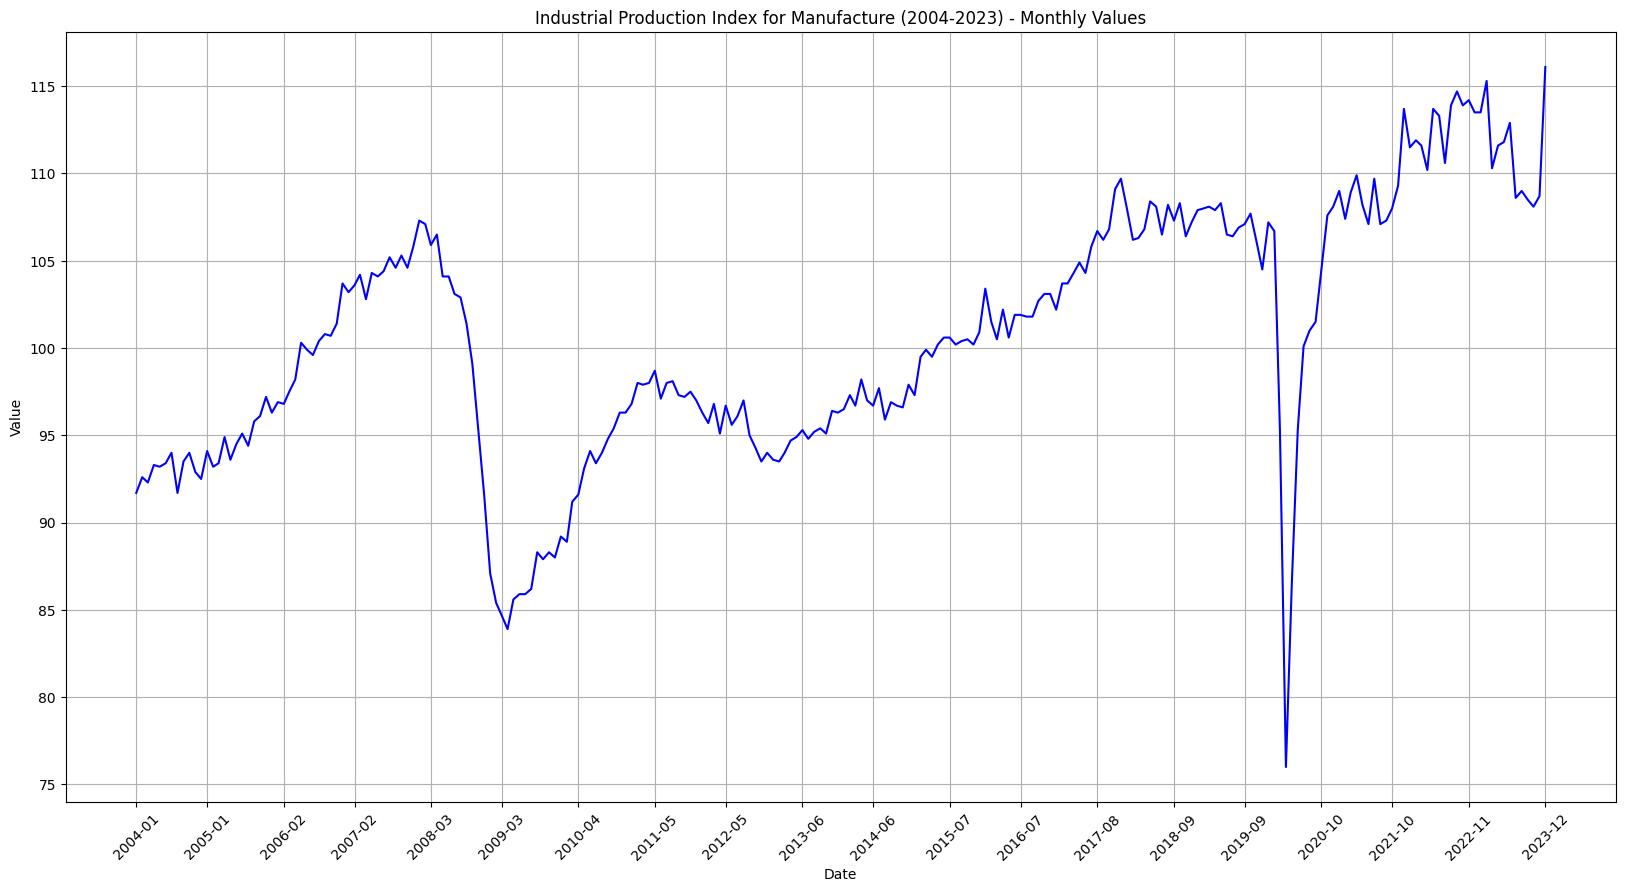

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df.index, df['IP'], label = 'IP Value', color = 'Blue')
# Set custom x-ticks to show fewer labels
tick_indices = np.linspace(0, len(df.index)-1, 20, dtype=int)  # 10 labels
ax.set_xticks(df.index[tick_indices])
ax.set_xticklabels(df.index[tick_indices].strftime('%Y-%m'), rotation=45)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Industrial Production Index for Manufacture (2004-2023) - Monthly Values')
plt.grid(True)
plt.show()

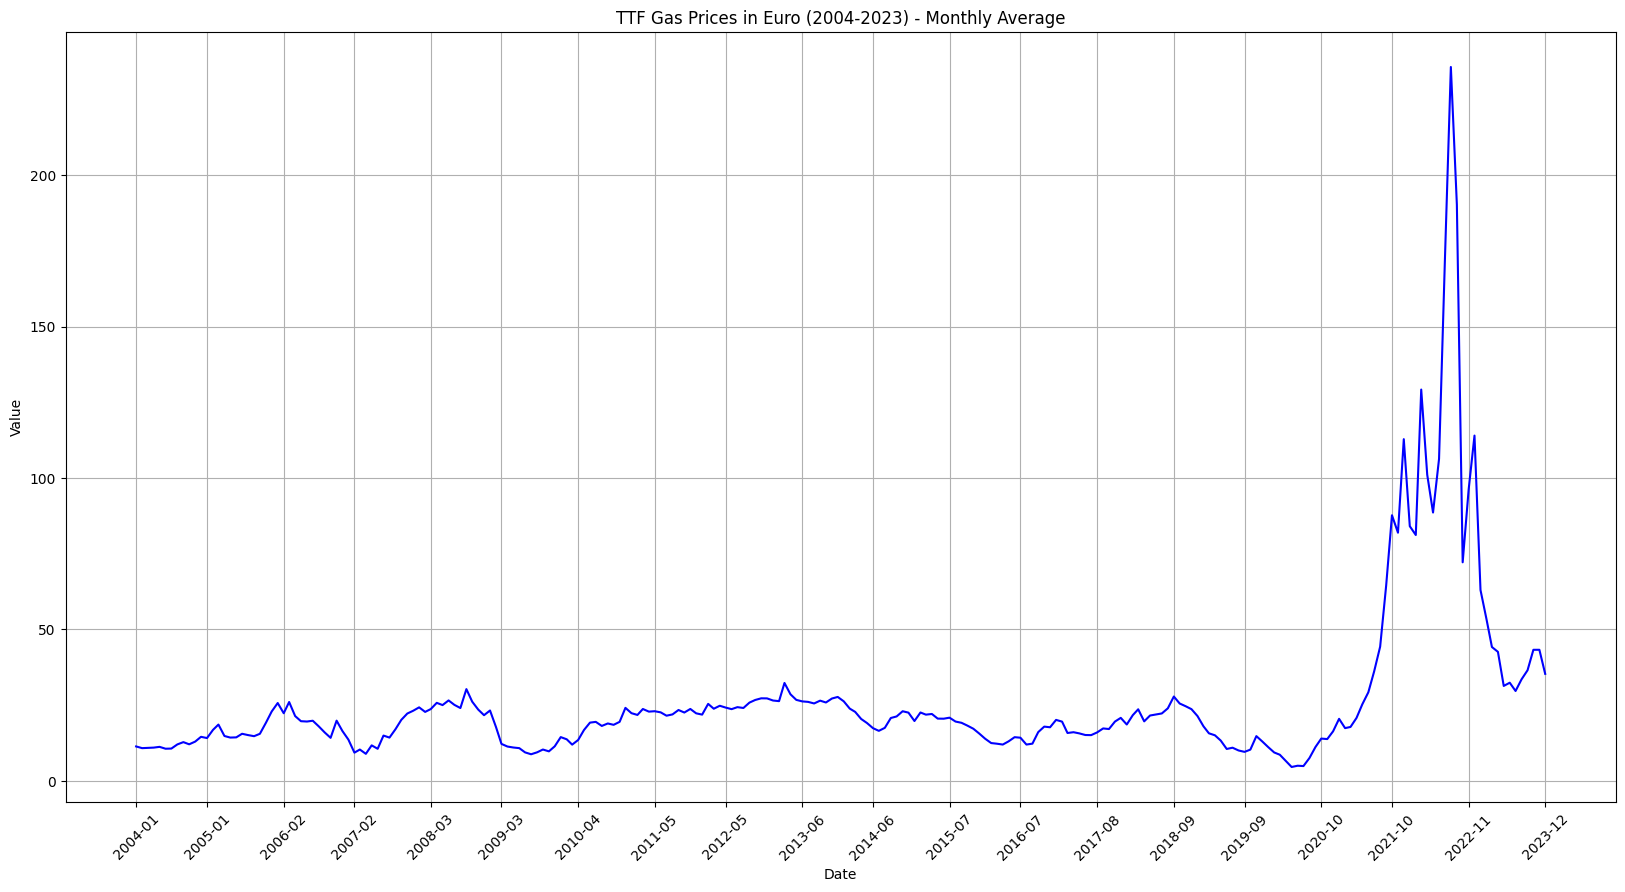

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
#ax.plot(df.index, df['OBS_VALUE'], label = 'IP Value', color = 'Blue')
ax.plot(df.index, df['GAS_PRICE'], label = 'Gas Price', color = 'Blue')

# Set custom x-ticks to show fewer labels
tick_indices = np.linspace(0, len(df.index)-1, 20, dtype=int)  # 10 labels
ax.set_xticks(df.index[tick_indices])
ax.set_xticklabels(df.index[tick_indices].strftime('%Y-%m'), rotation=45)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('TTF Gas Prices in Euro (2004-2023) - Monthly Average')
plt.grid(True)
plt.show()

In [8]:
df = df.reset_index()

<Axes: xlabel='Time'>

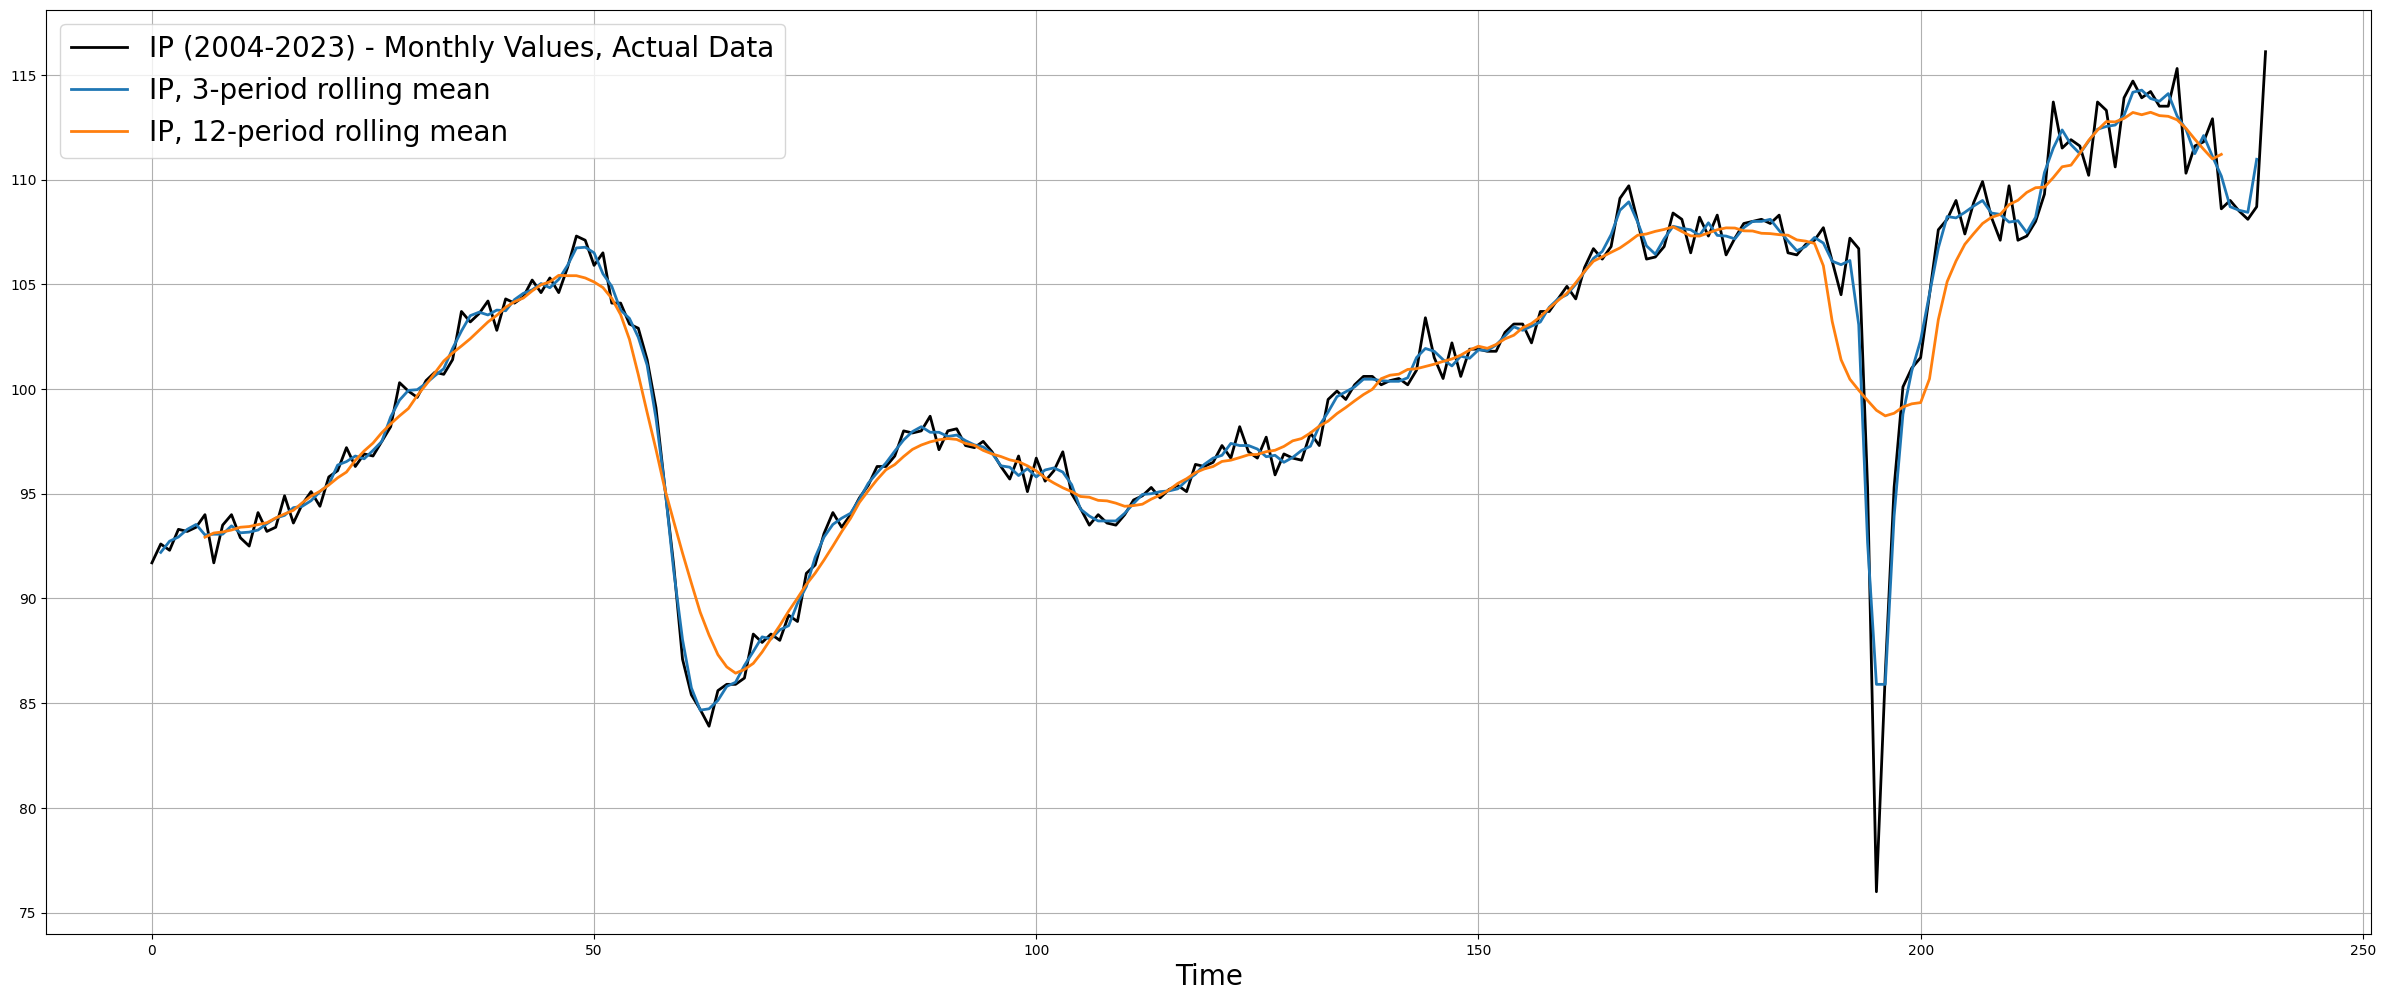

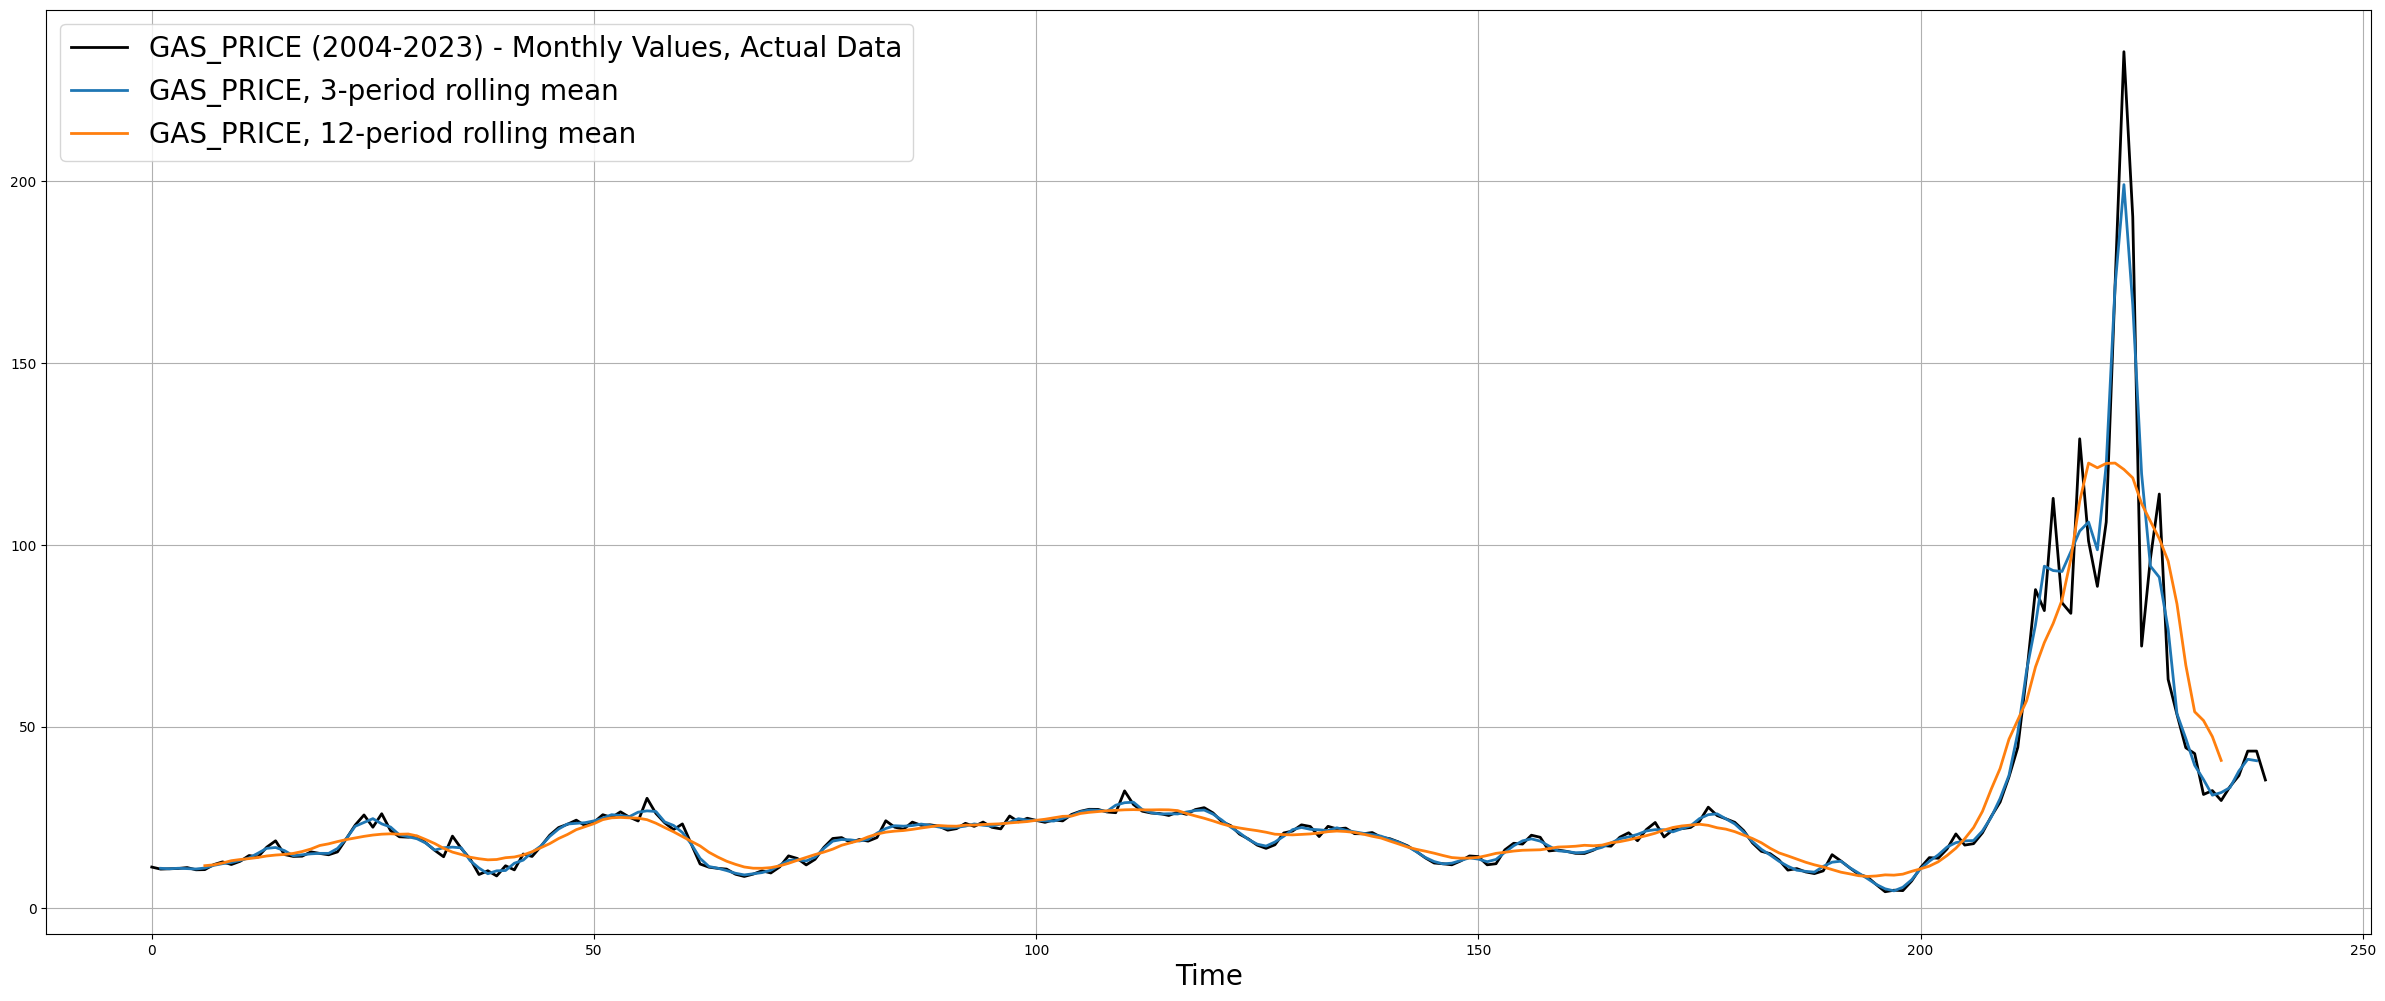

In [9]:
plot_rolling_mean(df, 'IP', [3,12], ylabel=None, title=None, start=0, end=None)
plot_rolling_mean(df, 'GAS_PRICE', [3,12], ylabel=None, title=None, start=0, end=None)

<Axes: xlabel='Time'>

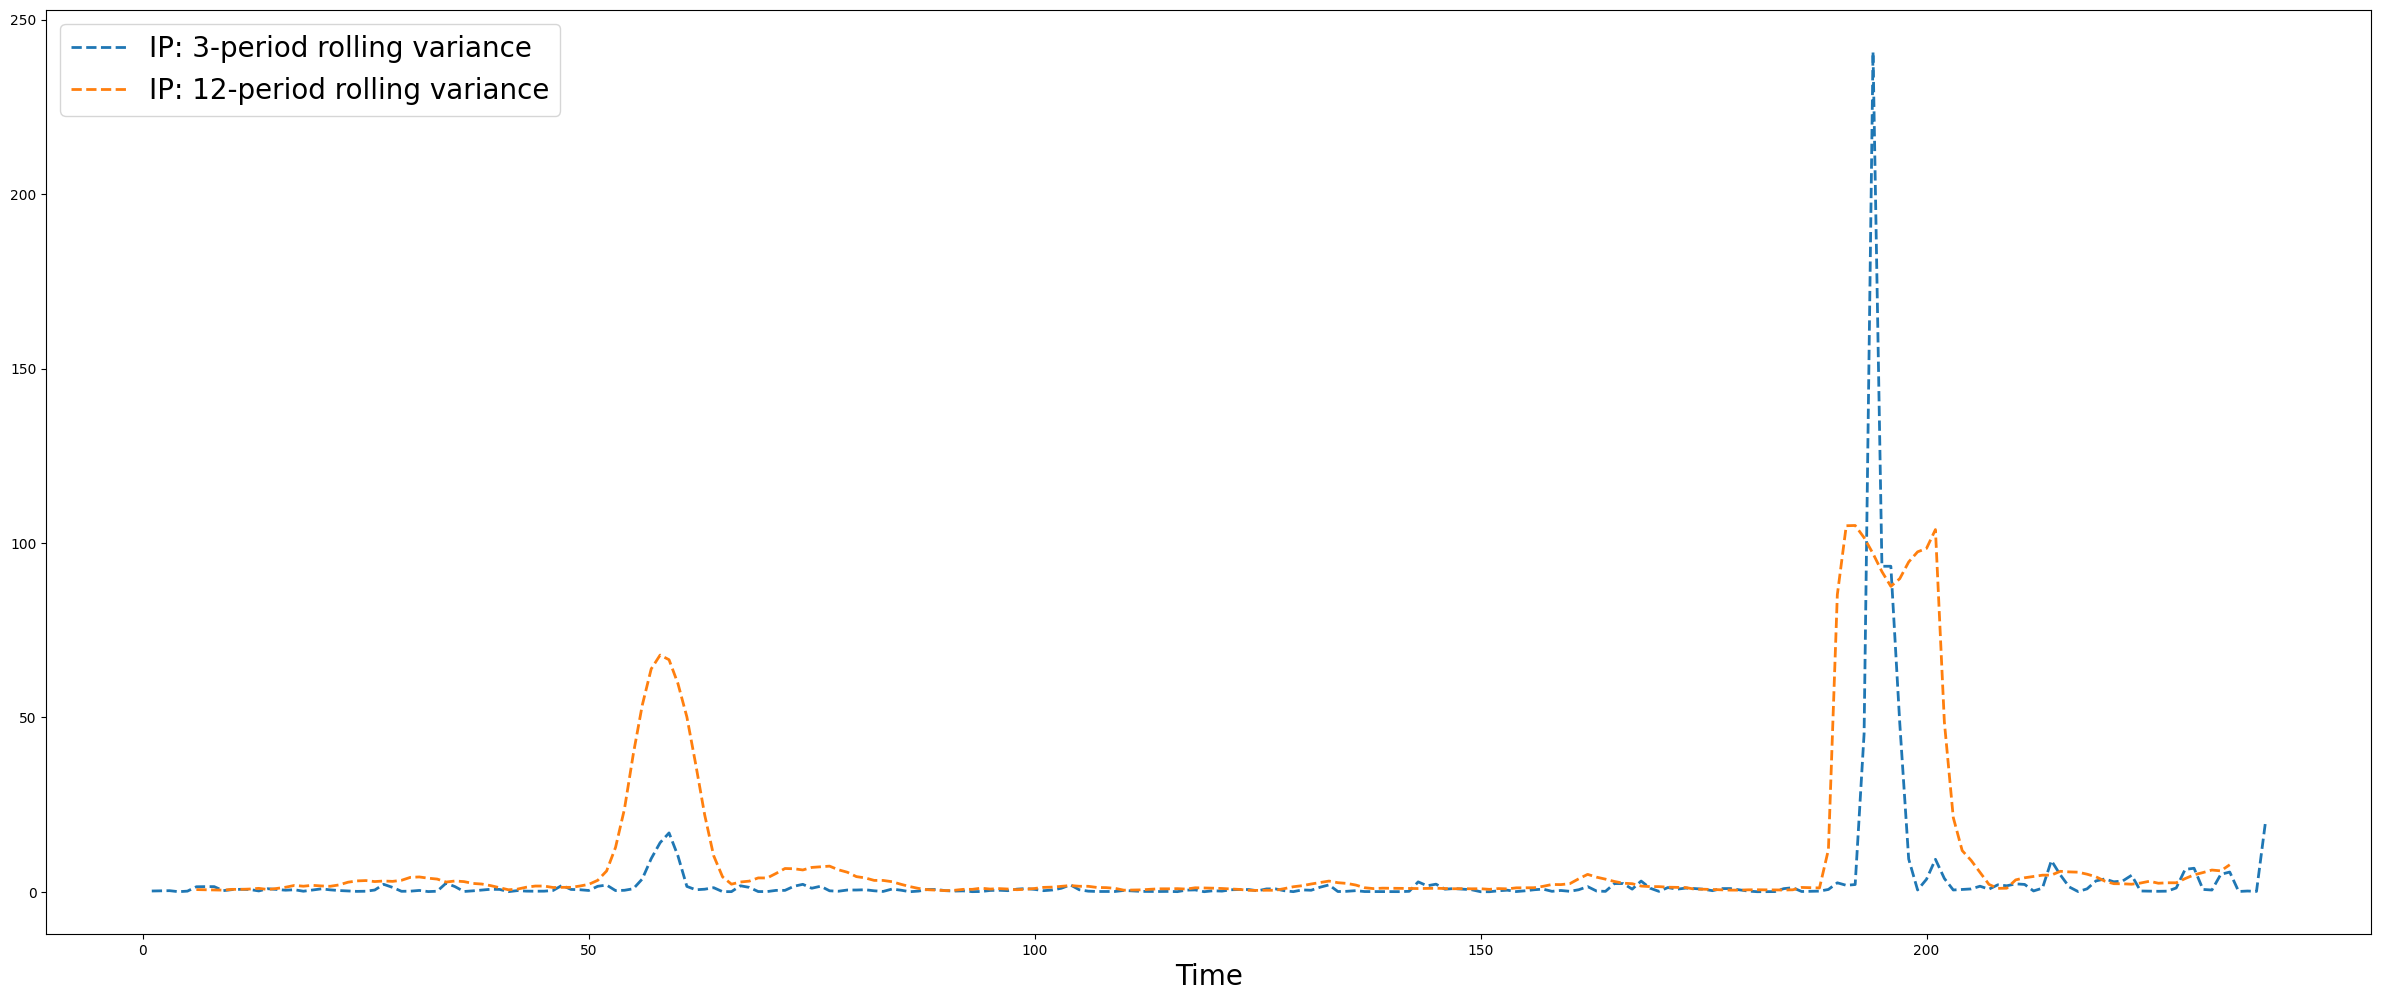

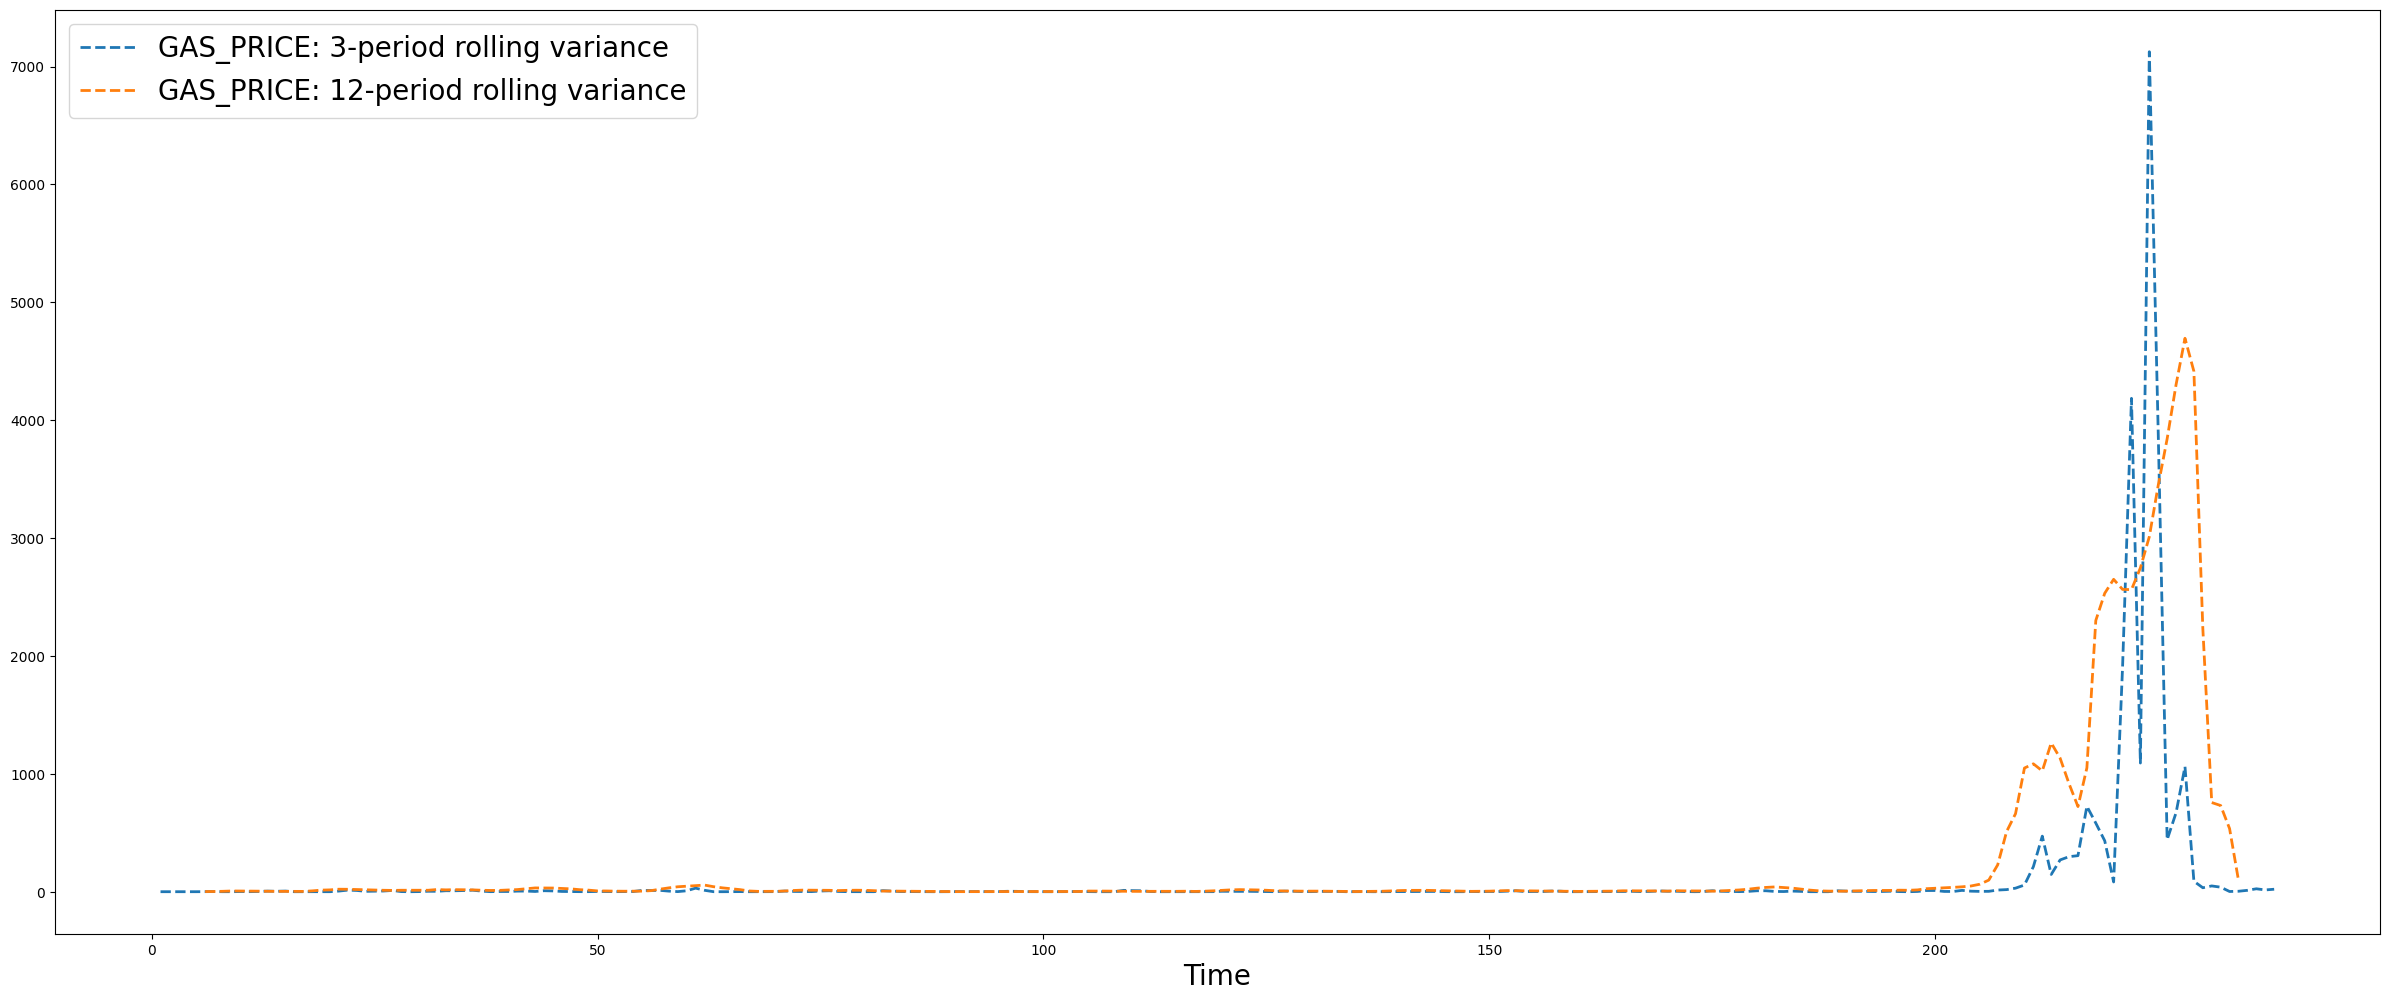

In [10]:
plot_rolling_variance(df, 'IP', [3,12], ylabel=None, title=None, start=0, end=None)
plot_rolling_variance(df, 'GAS_PRICE', [3,12], ylabel=None, title=None, start=0, end=None)

In [11]:
## Set the global font to be Times New Roman, size 20 (or any other size you want)
#mpl.rcParams['font.family'] = 'Arial'
#mpl.rcParams['font.size'] = 20
#
## Increase the size of year numbers on the plots
#mpl.rcParams['xtick.labelsize'] = 20
#
## Set the background style to white
#sns.set_style("white")
#
## Calcluate rolling mean
#rolling_ip_q = df['IP'].rolling(3, center=True).mean()
#rolling_ip_y = df['IP'].rolling(12, center=True).mean()
#
#rolling_gp_q = df['GAS_PRICE'].rolling(3, center=True).mean()
#rolling_gp_y = df['GAS_PRICE'].rolling(12, center=True).mean()
#
#ax = plot_series(df, 'IP')
#ax.plot(rolling_ip_q, linestyle='-', linewidth=2, label='Quarterly rolling mean - IP index')
#
#ax = plot_series(df, 'GAS_PRICE')
#ax.plot(rolling_gp_q, linestyle='-', linewidth=2, label='Quarterly rolling mean - Gas Prices')
#
##ax = plot_series(df, 'IP')
##ax.plot(rolling_ip_y, linestyle='-', linewidth=2, label='Annual rolling mean - IP index')
##
##ax = plot_series(df, 'GAS_PRICE')
##ax.plot(rolling_gp_y, linestyle='-', linewidth=2, label='Annual rolling mean - Gas Prieces')

## Seasonal Decomposition

La seasonal decomposition è stata effettuata con la funzione "seasonal_decompose" di python. La funzione richiede tre argomenti:
- La serie storica da analizzare
- il metodo "additivo" (quando la variazione dei valori della serie è costante nel tempo) o "moltiplicativo" (quando la variazione dei valori della serie aumenta nel tempo). Vedendo che le serie, a parte nei periodi di crisi (covid, GFC e invasione Ucraina) mantengono una variazione dei valori costante, ho scelto il metodo additivo.
- La finestra di tempo per la seasonal decomposition (1 = annual, 4 = quarterly, 12 = monthly, 365 = daily etc). Ho scelto di confrontare la decomposizione per periodi annuali, trimestrali e mensili. 

La funzione riporta 4 plot per la serie storica analizzata:
- La serie storica "raw", cioé il normale plot della serie.
- Stagionalità
- Trend
- Residui dovuti alla rimozione di trend e stagionalità

Dalle analisi appare che a livello annuale, sia per IP che per GP



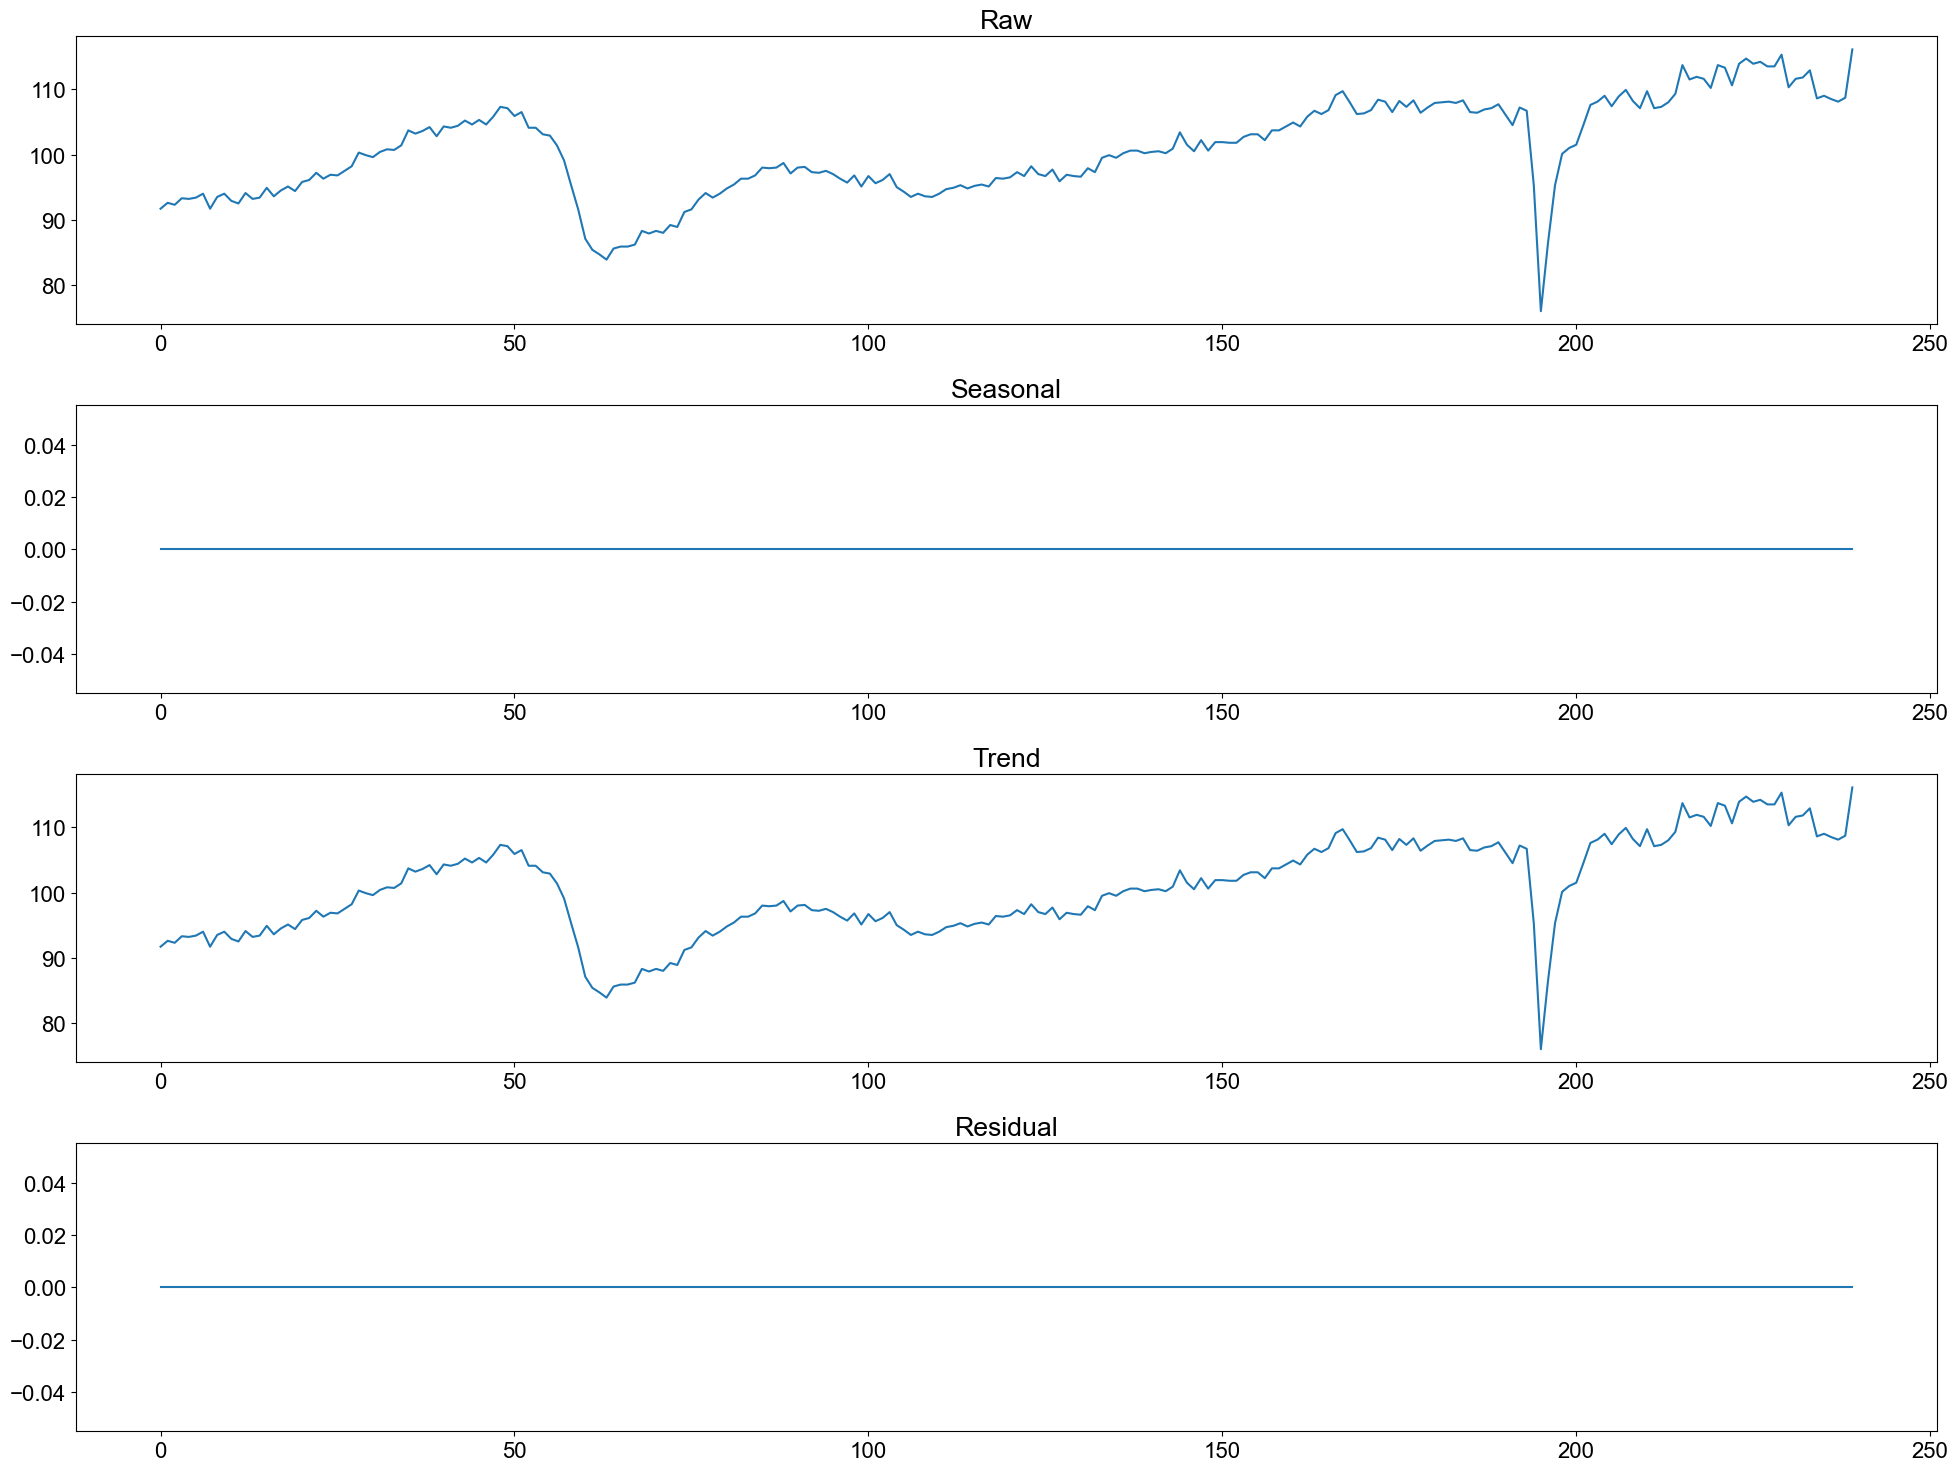

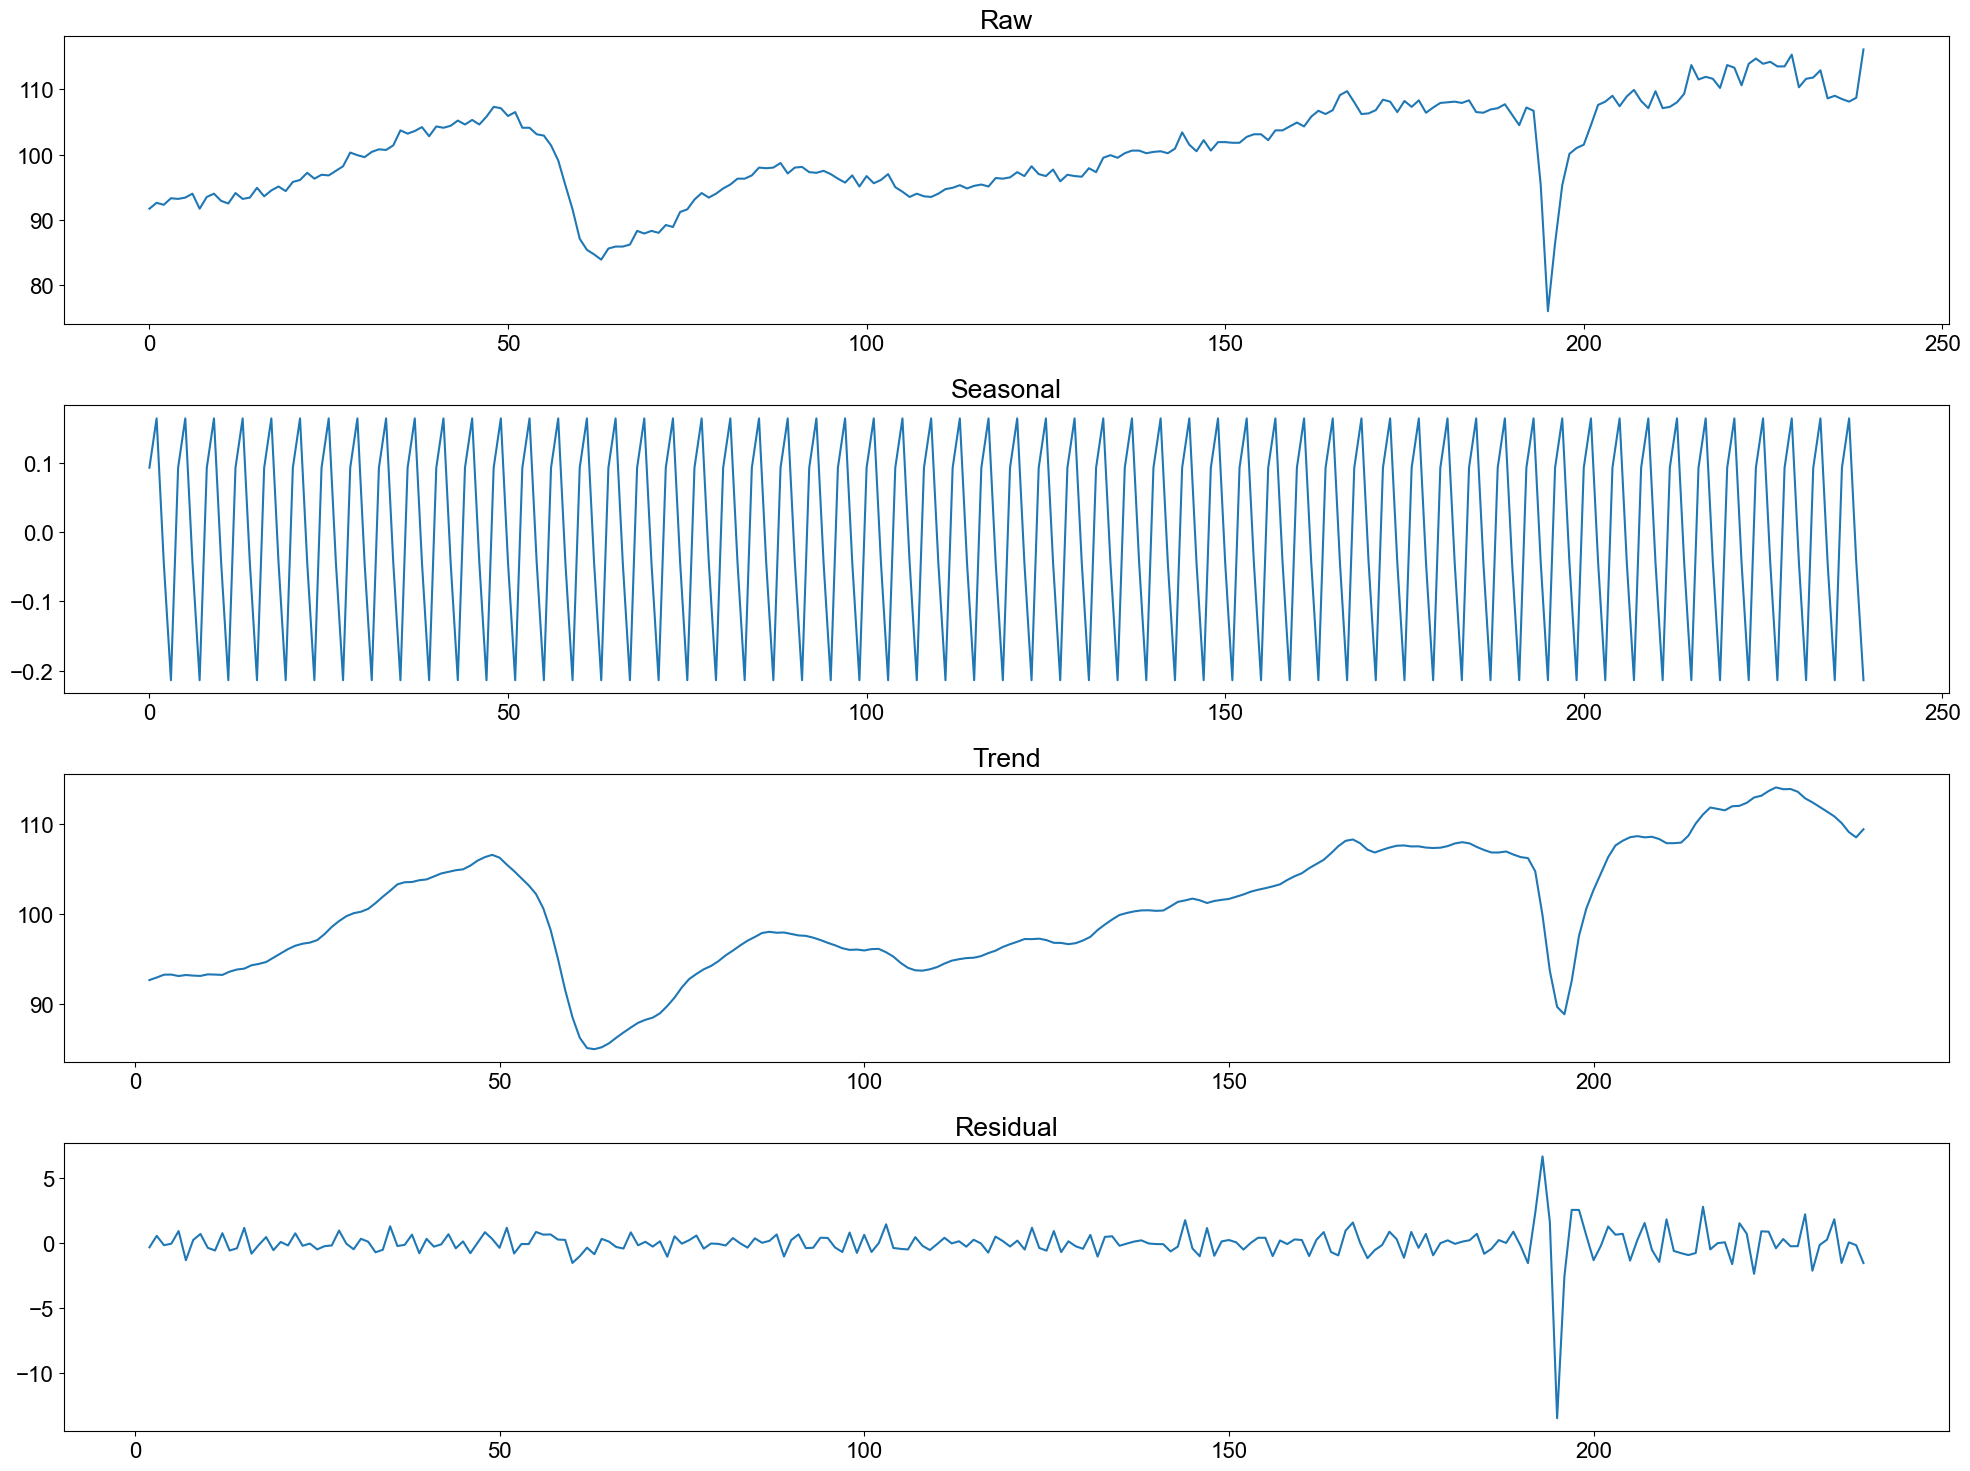

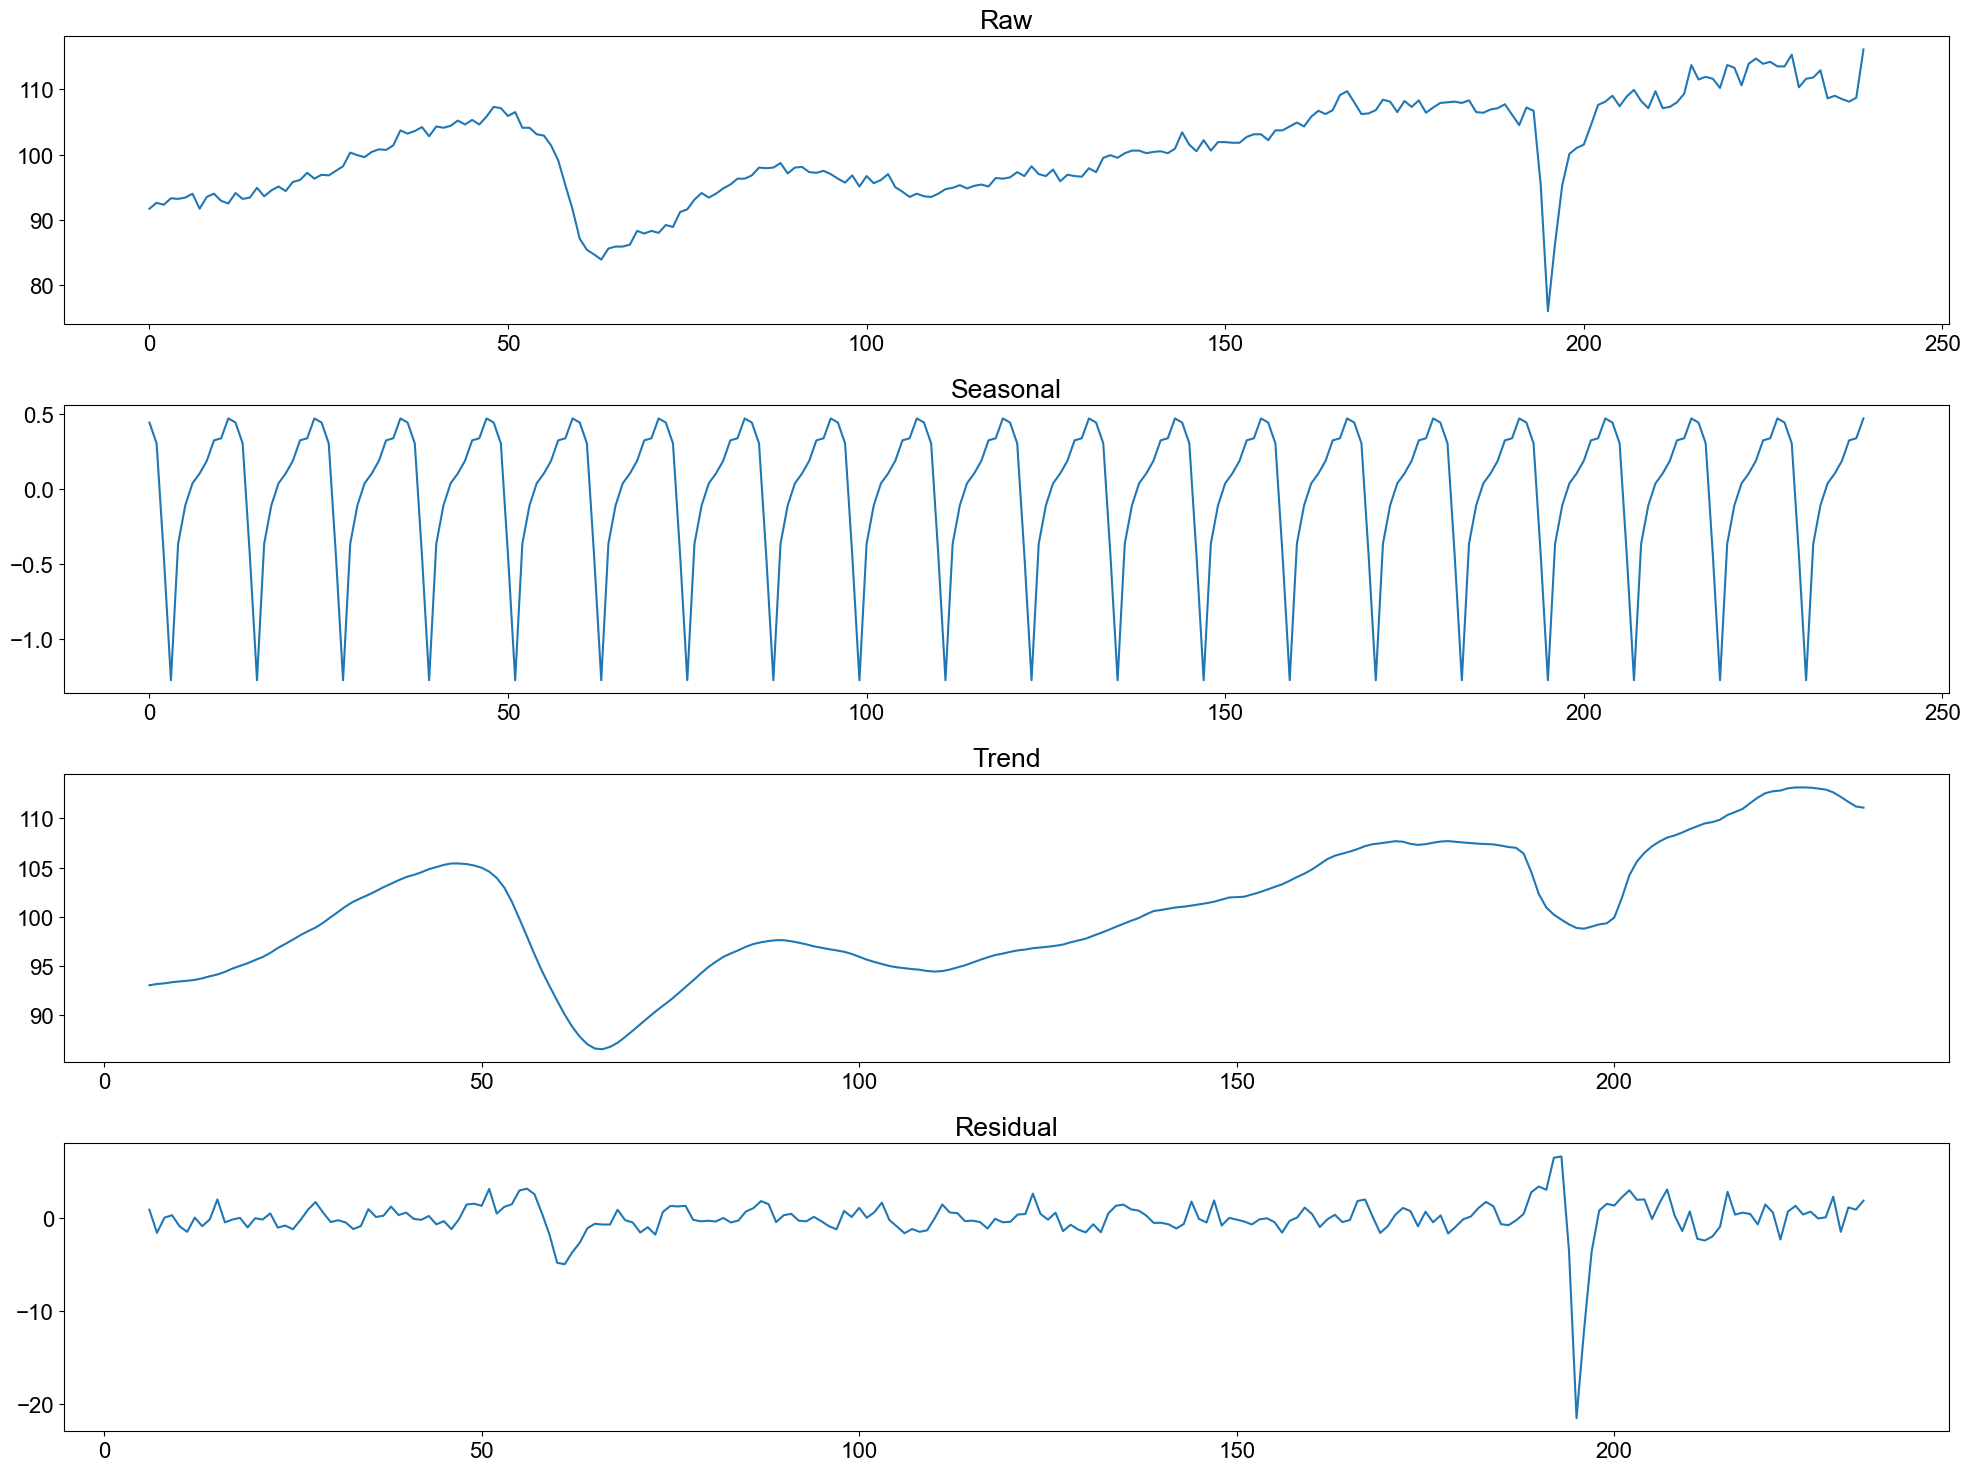

In [12]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16

# Set the global background color to be white
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'

periods = [1,4,12]

for p in periods:
    res1 = sm.tsa.seasonal_decompose(df['IP'], model='additive', period=p)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 15))
    res1.observed.plot(ax=ax1, title='Raw')
    res1.seasonal.plot(ax=ax2, title='Seasonal')
    res1.trend.plot(ax=ax3, title='Trend')
    res1.resid.plot(ax=ax4, title='Residual')
    plt.tight_layout()
    plt.show()

In [13]:
#plot_decomposition(df, column='IP', model='additive', window_sizes=periods)

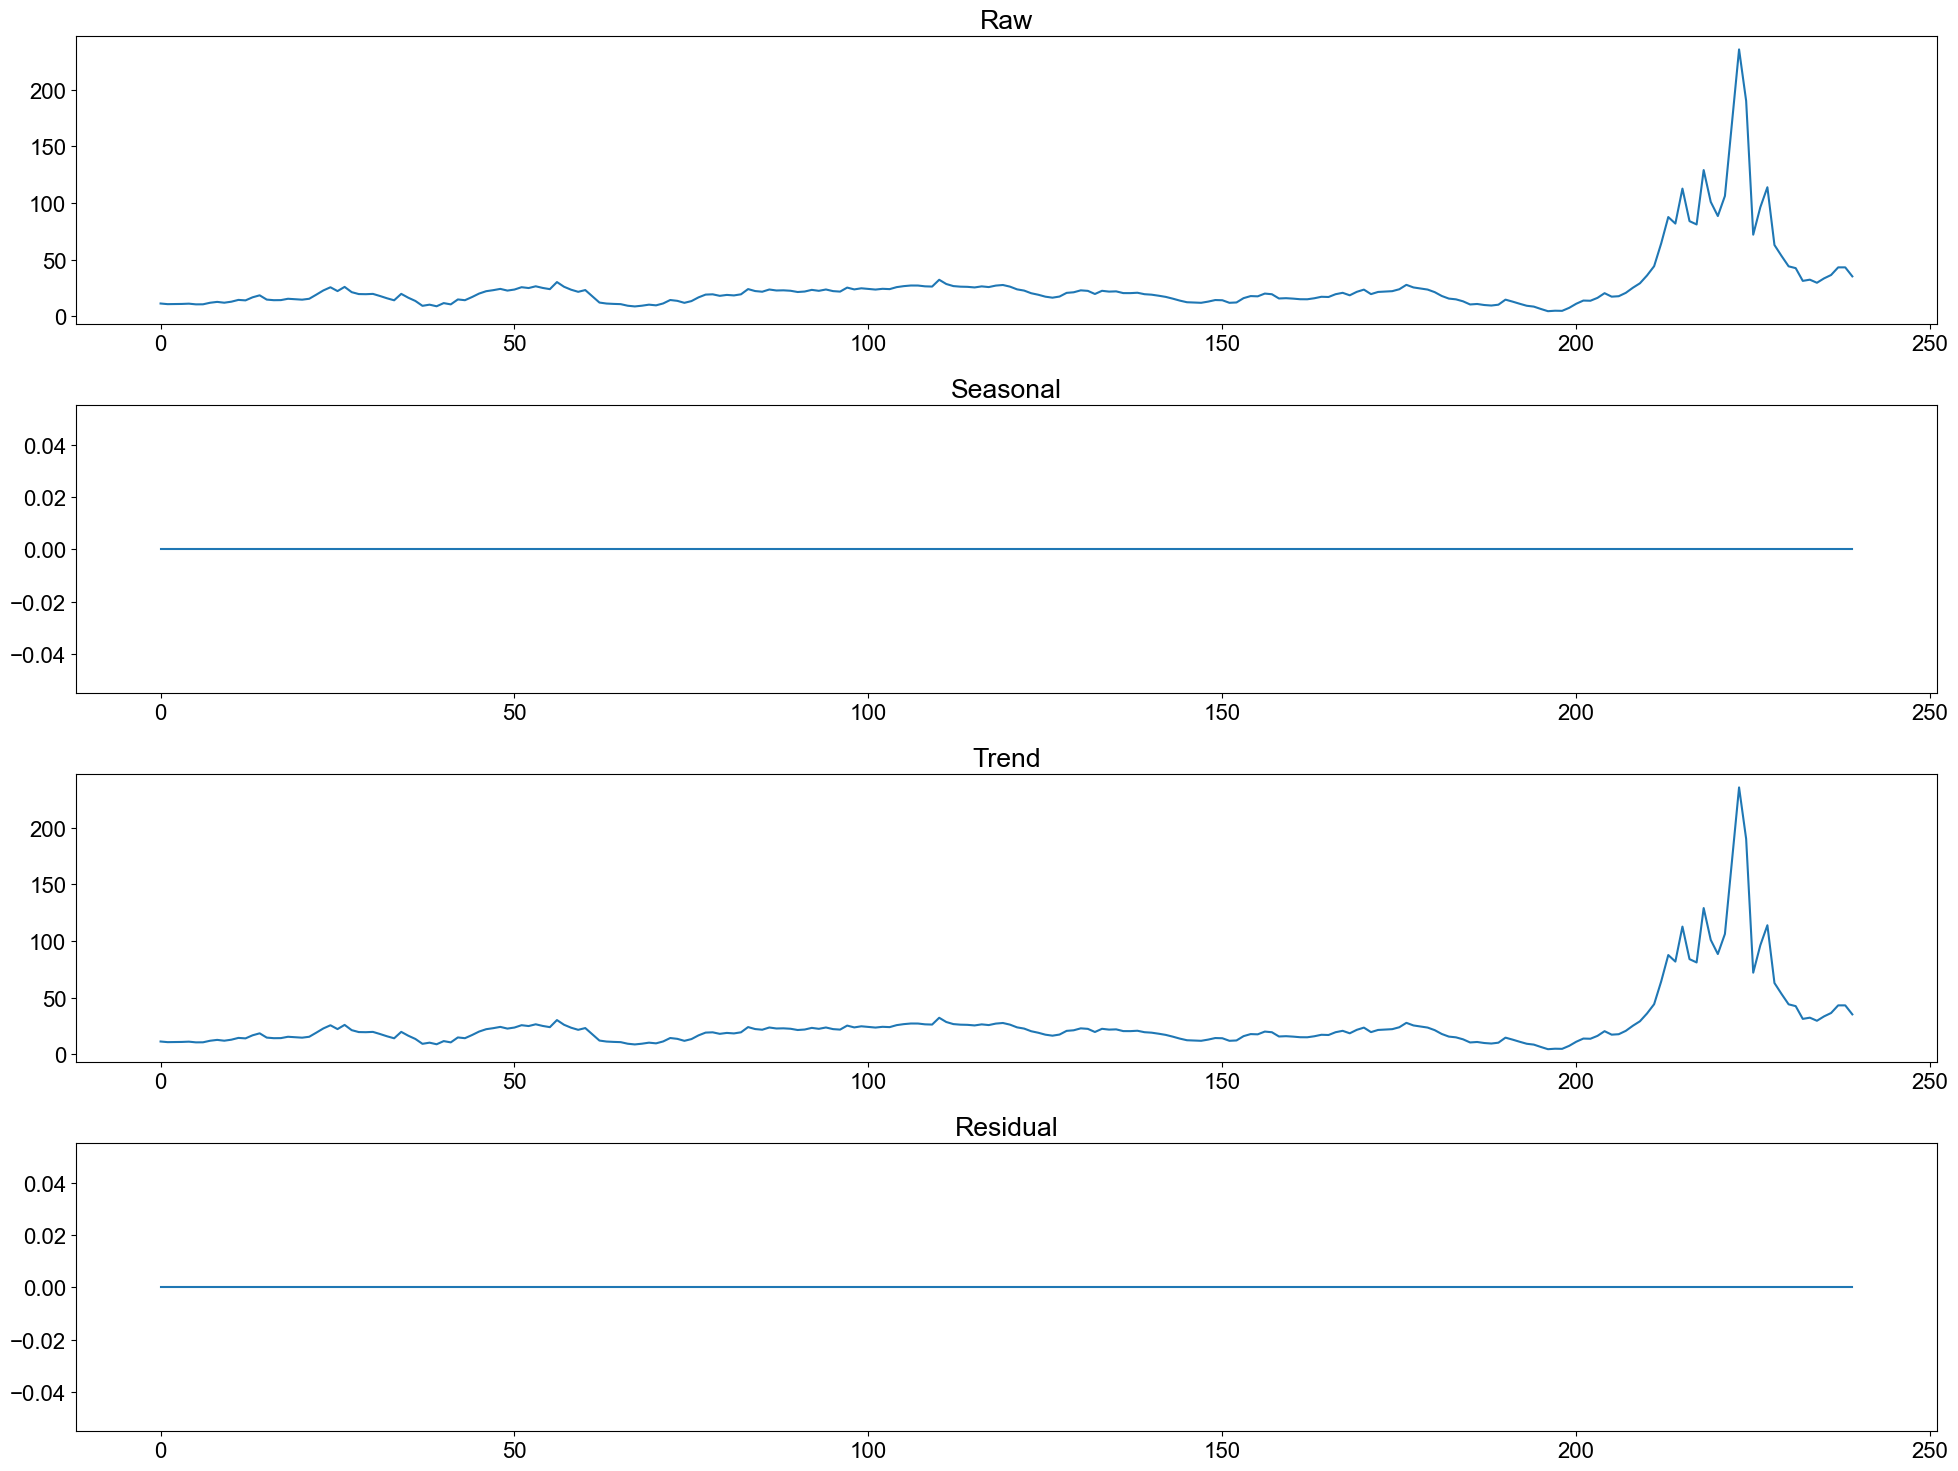

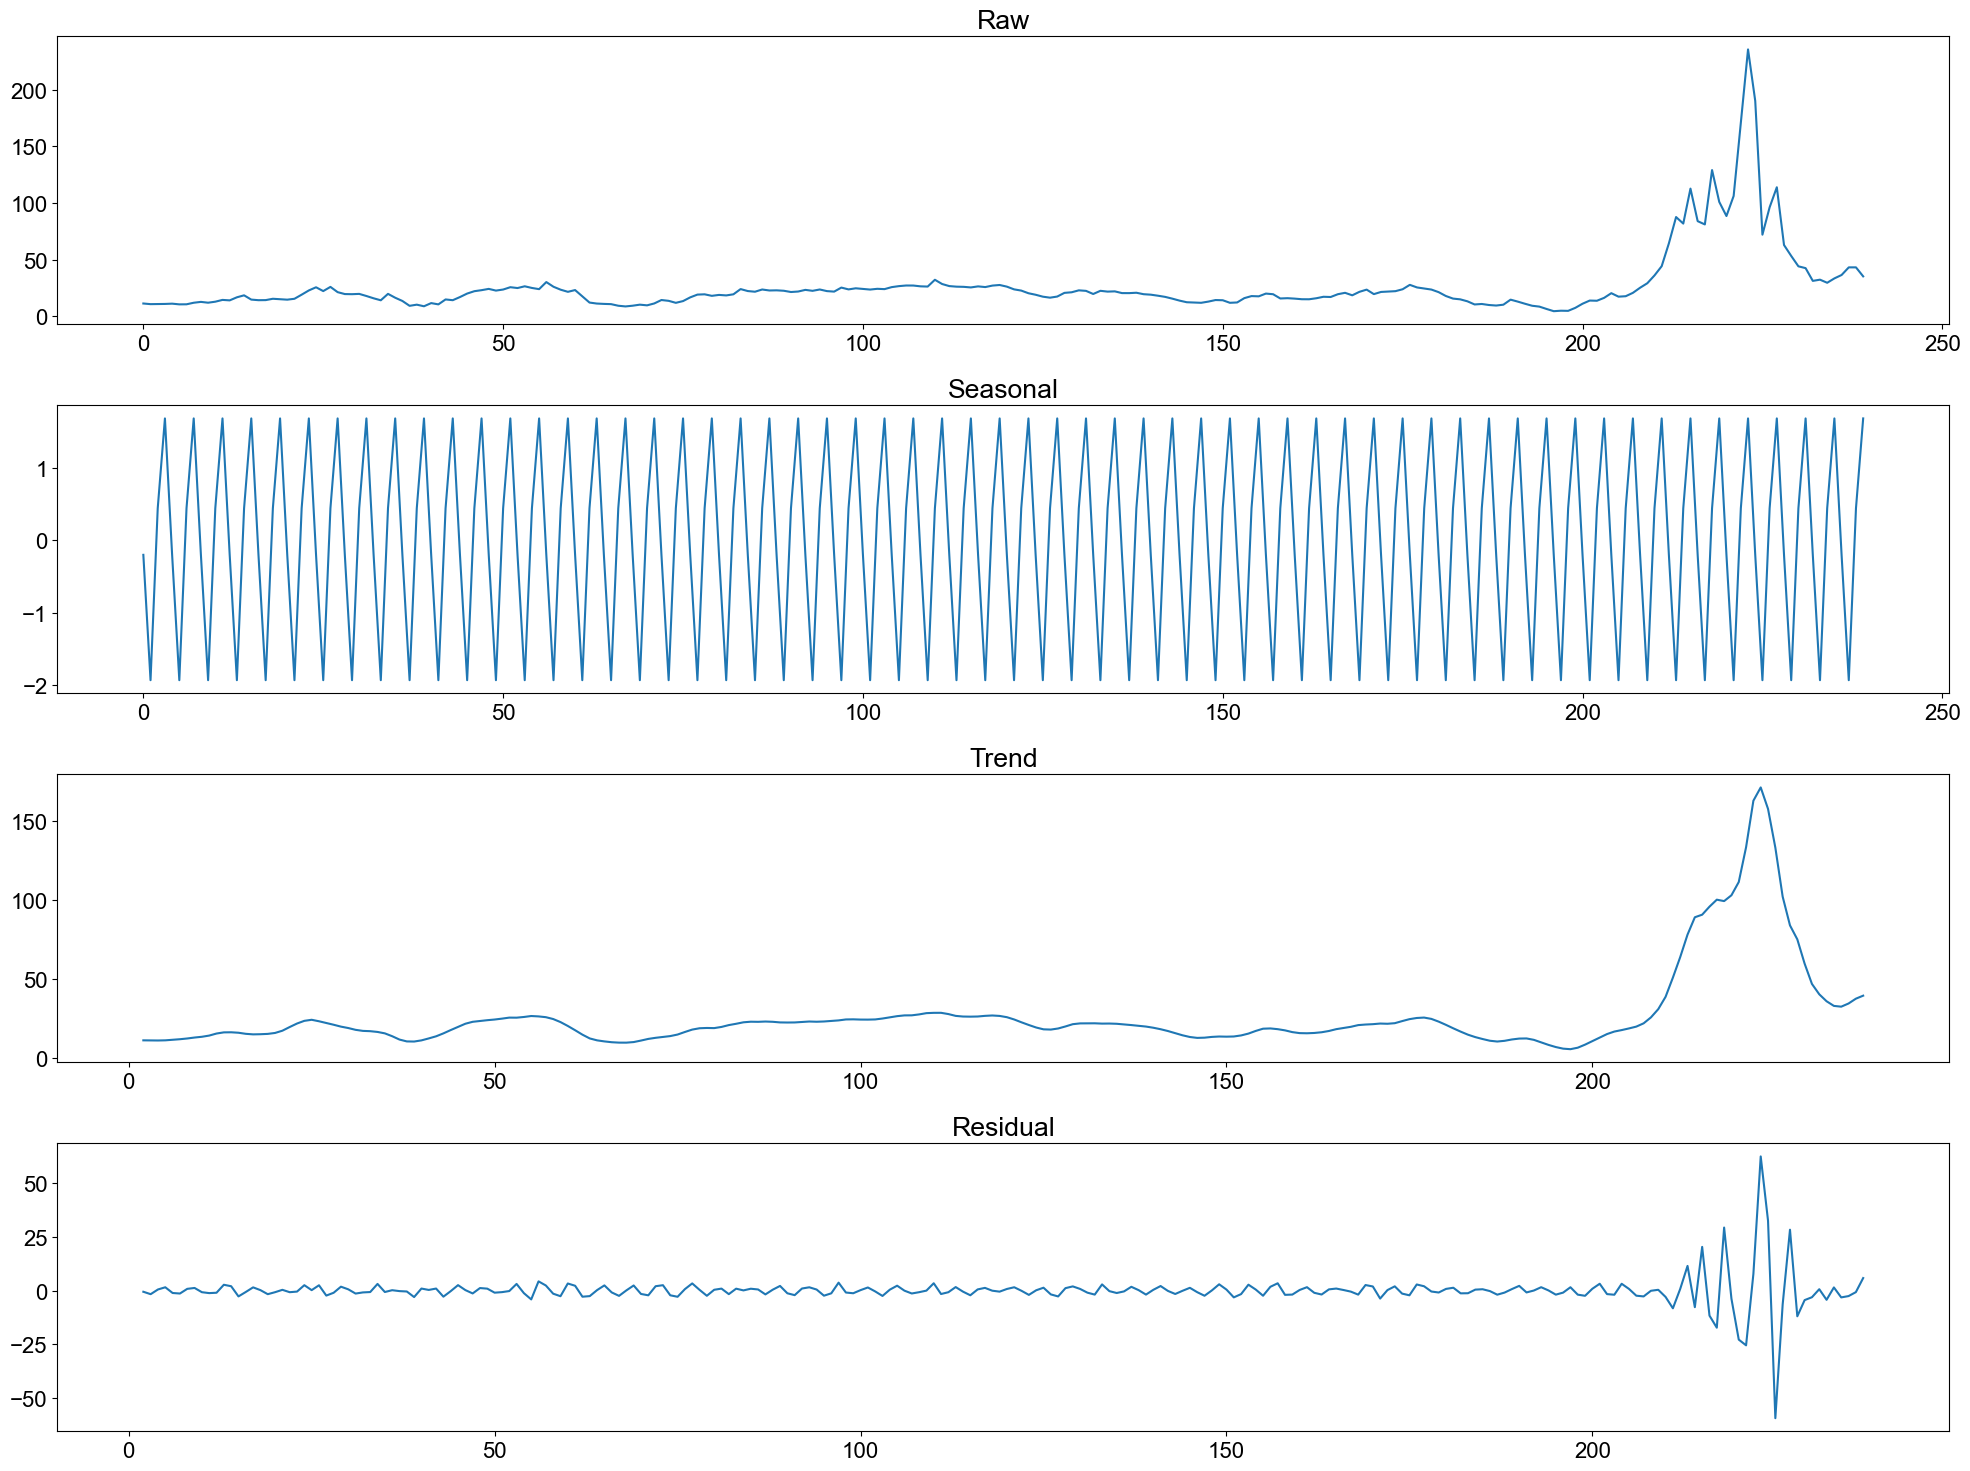

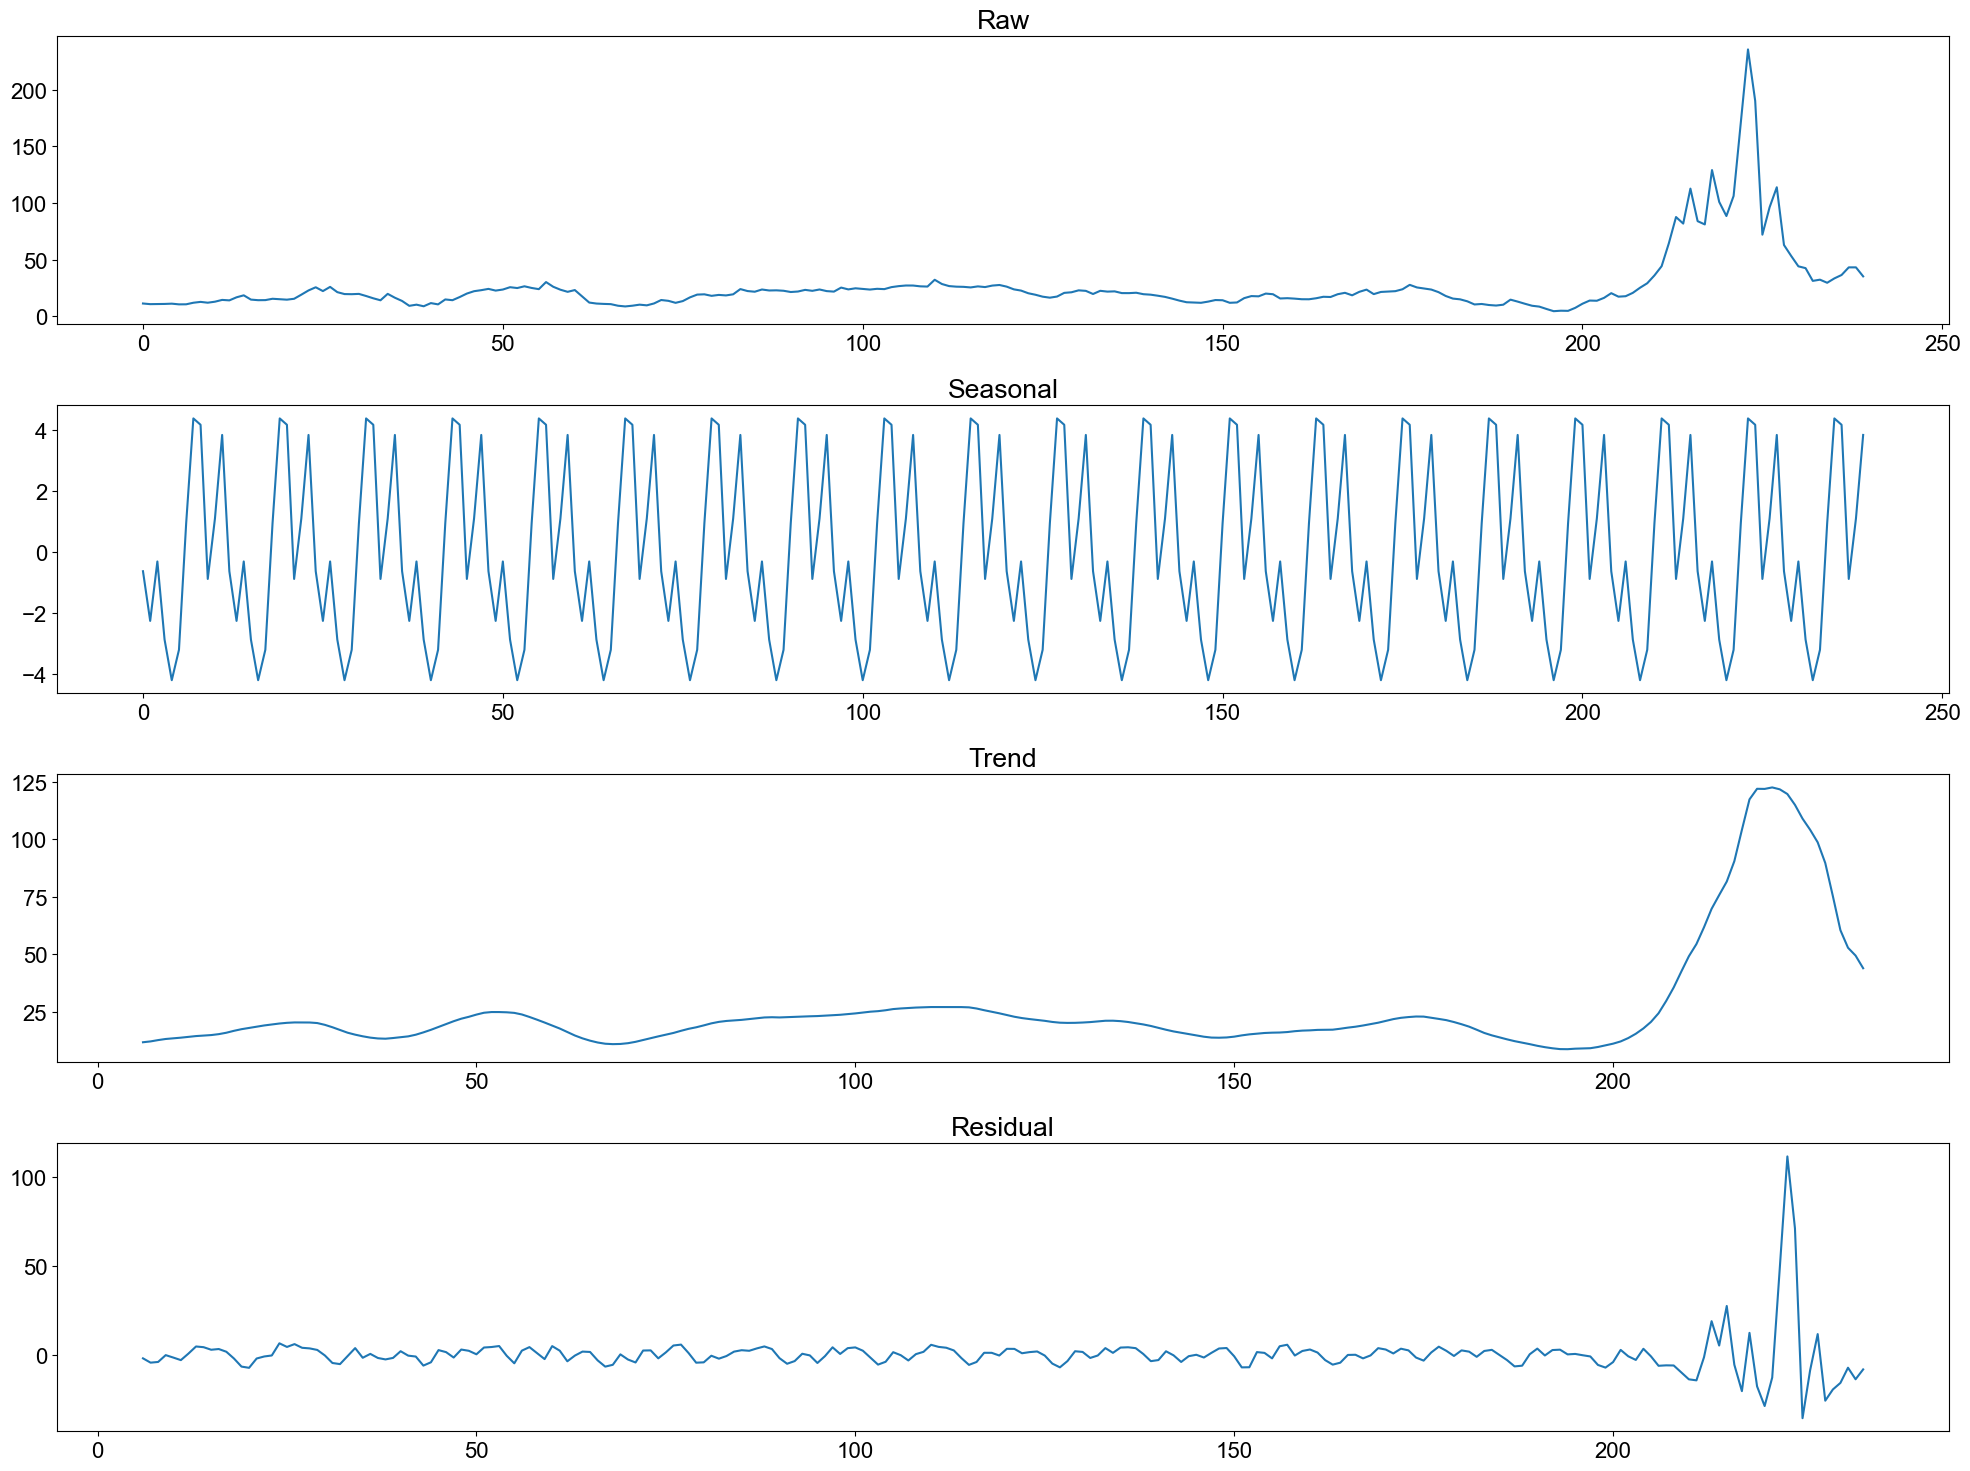

In [14]:
for p in periods:
    res2 = sm.tsa.seasonal_decompose(df['GAS_PRICE'], model='additive', period=p)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 15))
    res2.observed.plot(ax=ax1, title='Raw')
    res2.seasonal.plot(ax=ax2, title='Seasonal')
    res2.trend.plot(ax=ax3, title='Trend')
    res2.resid.plot(ax=ax4, title='Residual')
    plt.tight_layout()
    plt.show()

In [15]:
shapiro_ip = stats.shapiro(df.IP)
print(shapiro_ip.statistic, shapiro_ip.pvalue)

0.9820492276568733 0.003936813502513107


In [16]:
shapiro_gp = stats.shapiro(df.GAS_PRICE)
print(shapiro_gp.statistic, shapiro_gp.pvalue)

0.5003656713560726 1.51707562653176e-25


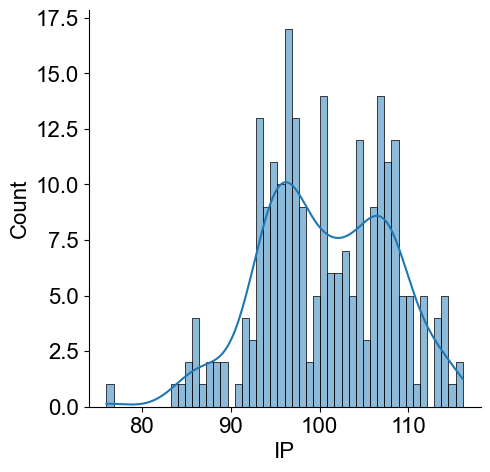

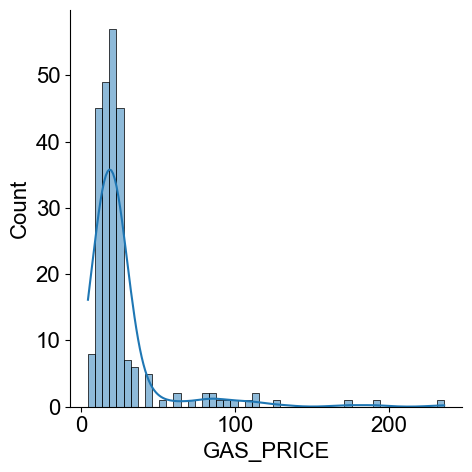

In [17]:
sns.displot(df, x="IP", bins = 50, kde= True)
sns.displot(df, x="GAS_PRICE", bins = 50, kde= True)

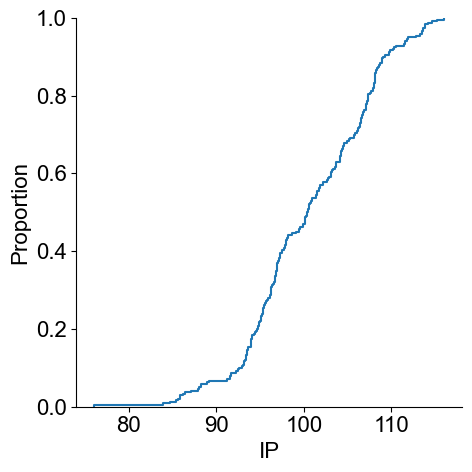

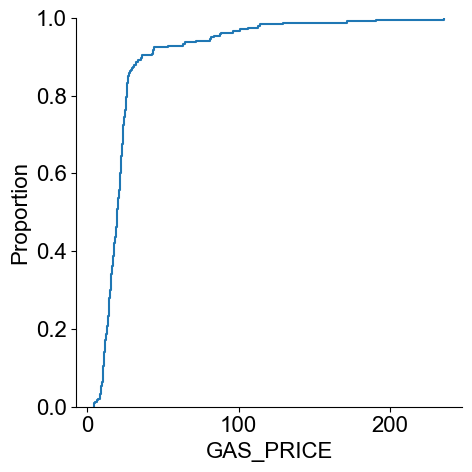

In [18]:
sns.displot(df, x="IP", kind="ecdf")
sns.displot(df, x="GAS_PRICE", kind="ecdf")

### Correlation Analysis

In [19]:
corr1 = stats.pearsonr(df.IP, df.GAS_PRICE)
print(corr1.correlation)
print(corr1.pvalue)
#print(corr.confidence_interval)

0.47161802228369726
1.0762682417224782e-14


## ARIMA Test

In [20]:
#df['log_GAS_PRICE'] = np.log(df.GAS_PRICE)
#df['log_GAS_PRICE_t1'] = np.log(df.GAS_PRICE_t1)
#
#df['log_IP'] = np.log(df.IP)
#df['log_IP_t1'] = np.log(df.IP_t1)

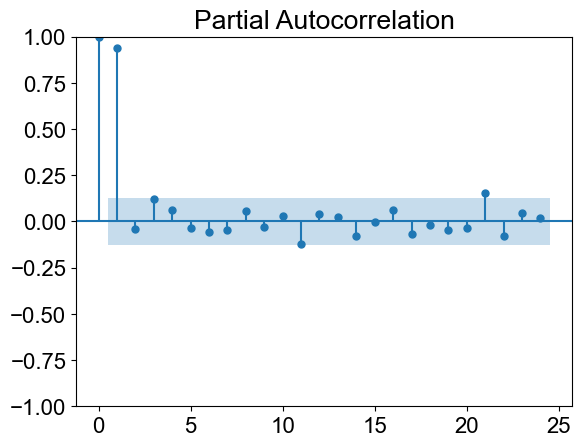

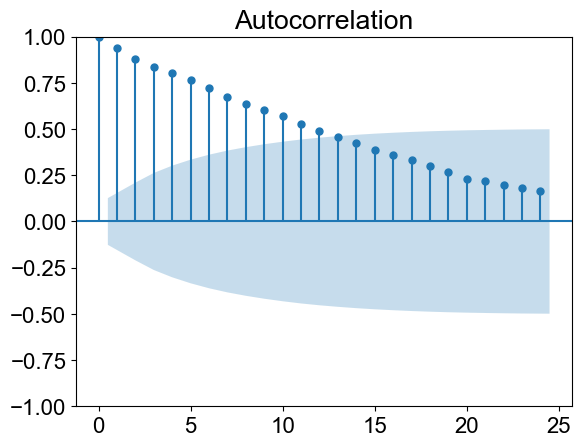

In [21]:
pacf_ip = plot_pacf(df.IP, lags=24)

acf_ip = plot_acf(df.IP, lags=24)

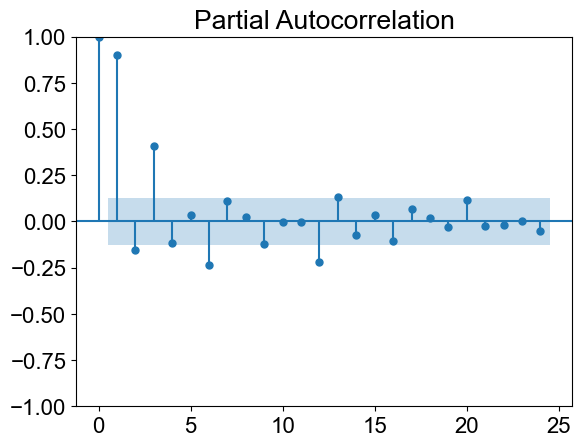

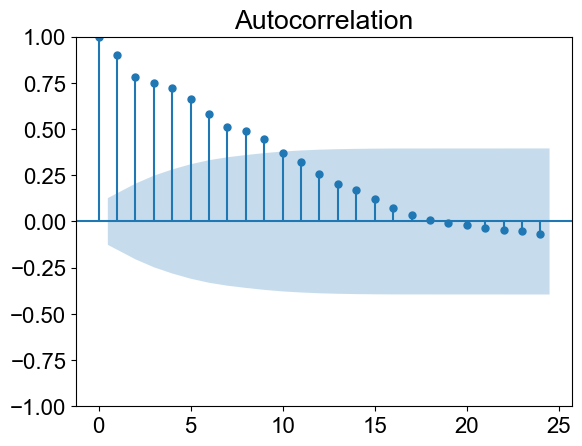

In [22]:
pacf_gp = plot_pacf(df.GAS_PRICE, lags=24)

acf_gp = plot_acf(df.GAS_PRICE, lags=24)

In [23]:
adf_ip = adfuller(df.IP)
print('value',adf_ip[0])
print('p-value',adf_ip[1])

value -1.906419814446655
p-value 0.32904708060949134


In [24]:
adf_gp = adfuller(df.GAS_PRICE)
print('value', adf_gp[0])
print('p-value', adf_gp[1])

value -3.0384825158221362
p-value 0.03145357331650899


In [25]:
df['IP_t1'] = df.IP.shift(1)
df.IP_t1 = df.IP_t1.fillna(value=92.1)
df['IP_diffed'] = df['IP'] - df['IP_t1'] 

df['GAS_PRICE_t1'] = df.GAS_PRICE.shift(1)
df['GAS_PRICE_t1'] = df['GAS_PRICE_t1'].interpolate(method="nearest", order=3, limit=None, limit_direction='both').ffill().bfill()
df['GAS_PRICE_diffed'] = df['GAS_PRICE'] - df['GAS_PRICE_t1']

df.to_csv(os.path.join(path, "ue27_df.csv"))

In [26]:
corr2 = stats.pearsonr(df.IP, df.IP_t1)
print(corr2.correlation)
print(corr2.pvalue)

0.9524443208536406
7.945390377822594e-125


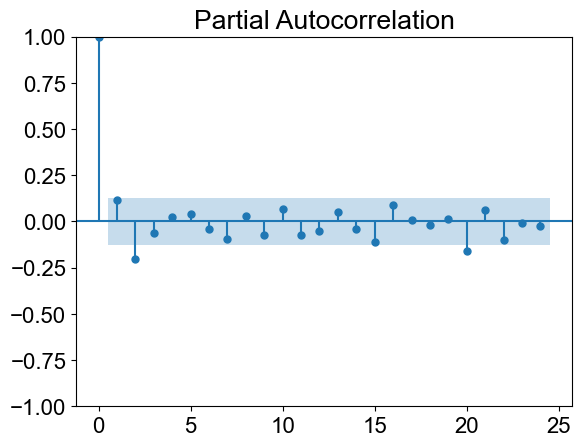

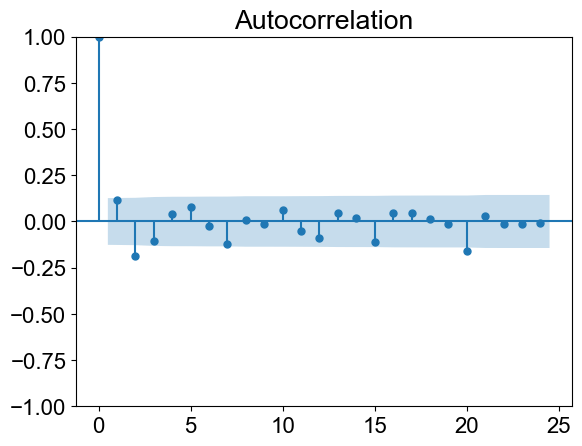

In [27]:
pacf = plot_pacf(df.IP_diffed, lags=24)

acf = plot_acf(df.IP_diffed, lags=24)

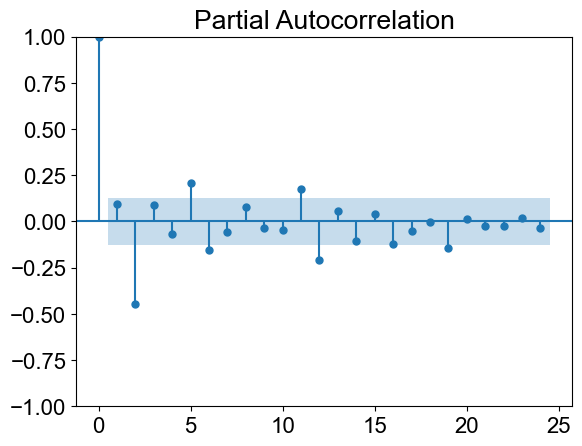

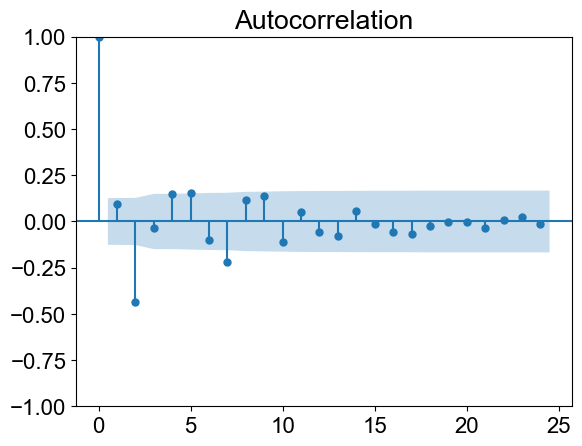

In [28]:
pacf = plot_pacf(df.GAS_PRICE_diffed, lags=24)

acf = plot_acf(df.GAS_PRICE_diffed, lags=24)

In [31]:
order_results, warning_orders = fit_arima_models(df['IP'], max_p=2, max_q=2, d=1, iterative=True)

In [32]:
print("Information Criteria for All ARIMA Orders:")
for order, results in order_results.items():
    print(f"ARIMA{order}: AIC = {results['AIC']:.2f}, BIC = {results['BIC']:.2f}, HQIC = {results['HQIC']:.2f}")

Information Criteria for All ARIMA Orders:
ARIMA(0, 1, 0): AIC = 1061.05, BIC = 1064.52, HQIC = 1062.45
ARIMA(0, 1, 1): AIC = 1057.76, BIC = 1064.71, HQIC = 1060.56
ARIMA(0, 1, 2): AIC = 1053.83, BIC = 1064.26, HQIC = 1058.04
ARIMA(1, 1, 0): AIC = 1059.69, BIC = 1066.64, HQIC = 1062.49
ARIMA(1, 1, 1): AIC = 1057.52, BIC = 1067.95, HQIC = 1061.72
ARIMA(1, 1, 2): AIC = 1054.10, BIC = 1068.01, HQIC = 1059.70
ARIMA(2, 1, 0): AIC = 1051.52, BIC = 1061.95, HQIC = 1055.72
ARIMA(2, 1, 1): AIC = 1052.87, BIC = 1066.78, HQIC = 1058.48
ARIMA(2, 1, 2): AIC = 1053.52, BIC = 1070.90, HQIC = 1060.52


In [33]:
best_model, best_rmse = find_best_model(order_results, 'AIC')

Best ARIMA order: (2, 1, 0) with RMSE: 1051.5165966917975


Summary for ARIMA order (2, 1, 0):

                               SARIMAX Results                                
Dep. Variable:                     IP   No. Observations:                  240
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -522.758
Date:                Tue, 17 Dec 2024   AIC                           1051.517
Time:                        15:22:10   BIC                           1061.946
Sample:                             0   HQIC                          1055.719
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1453      0.026      5.519      0.000       0.094       0.197
ar.L2         -0.2082      0.047     -4.427      0.000      -0.300      -0.116
sigma2         4

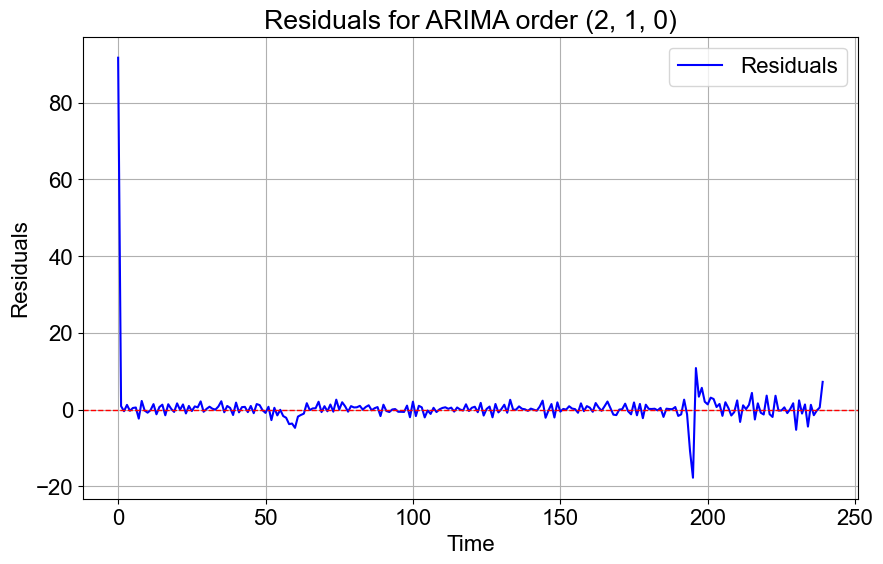

<Figure size 1000x600 with 0 Axes>

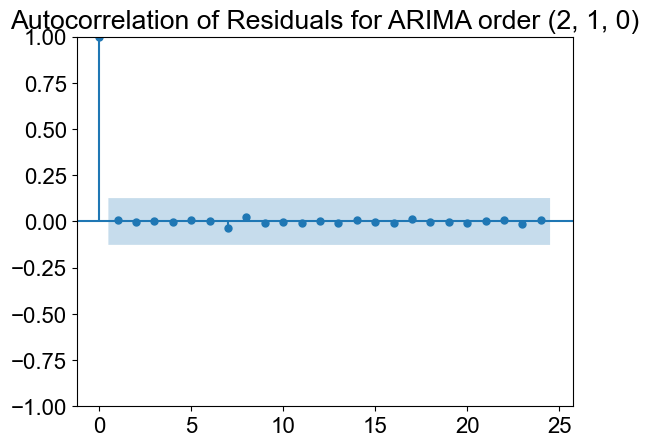

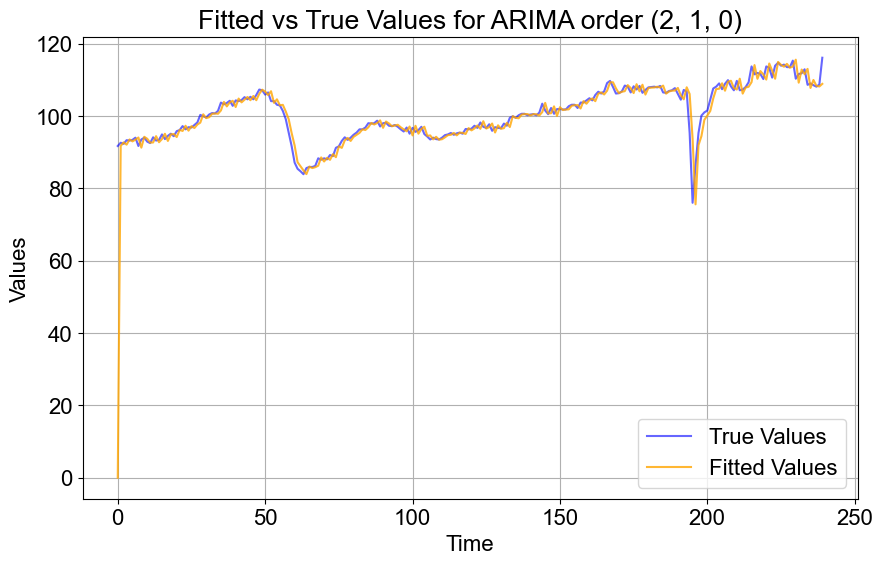

In [34]:
analyze_order((2, 1, 0), order_results)

Summary for ARIMA order (0, 1, 0):

                               SARIMAX Results                                
Dep. Variable:                     IP   No. Observations:                  240
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -529.523
Date:                Tue, 17 Dec 2024   AIC                           1061.045
Time:                        15:22:11   BIC                           1064.522
Sample:                             0   HQIC                          1062.446
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.9198      0.116     42.487      0.000       4.693       5.147
Ljung-Box (L1) (Q):                   3.16   Jarque-Bera (JB):              8544.52
Prob(Q):   

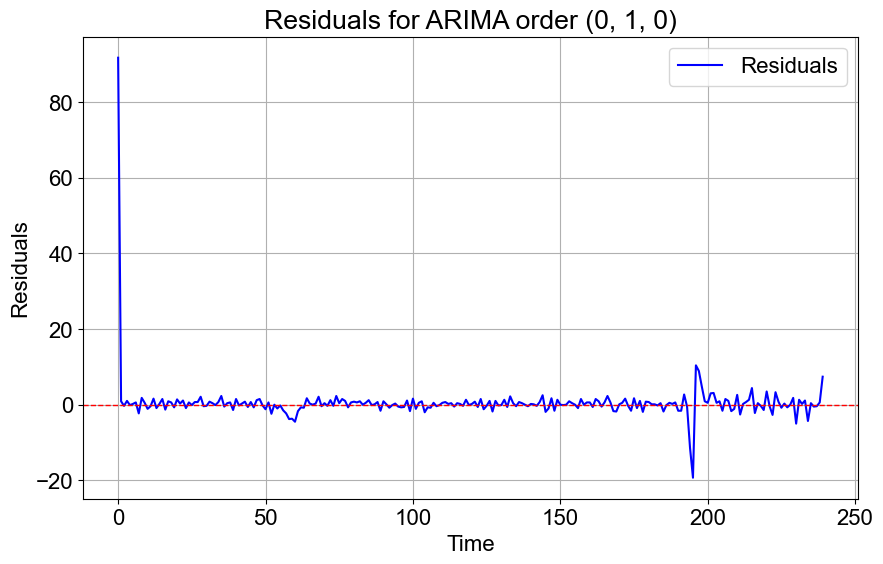

<Figure size 1000x600 with 0 Axes>

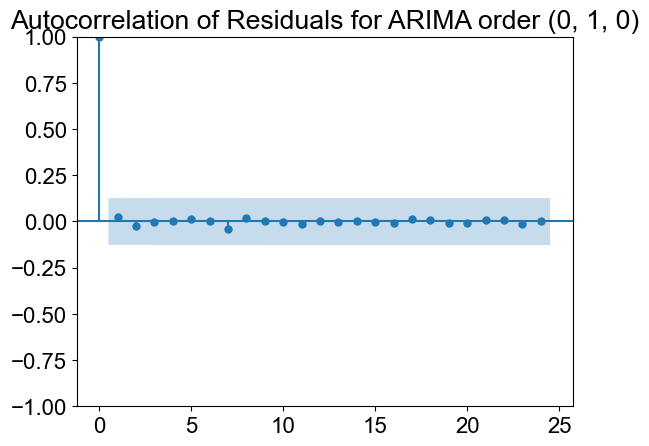

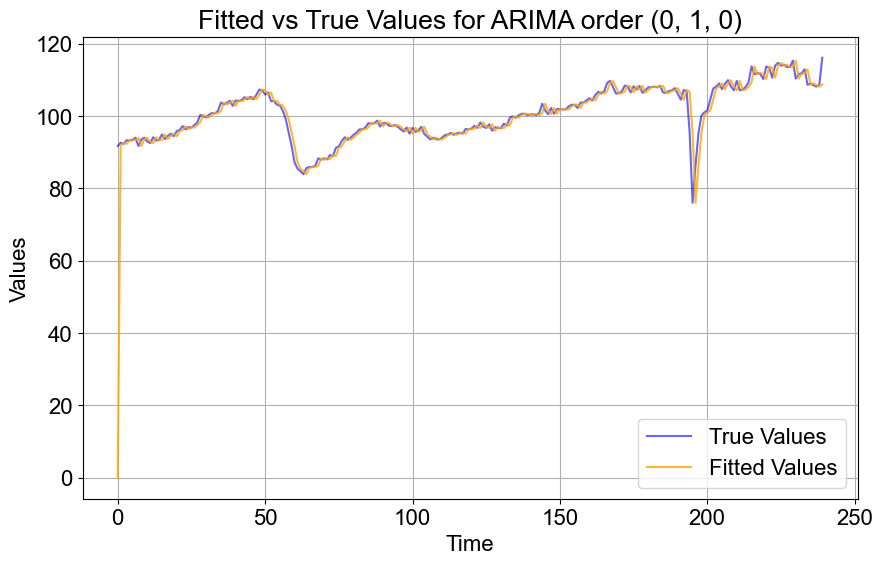

In [35]:
analyze_order((0, 1, 0), order_results)

In [36]:
ljung_box_test((0,1,0), order_results, lags=12)

Ljung-Box Test Results for ARIMA order (0, 1, 0):


Residuals show no significant autocorrelation (p-value >= 0.05).


,lb_stat,lb_pvalue
1,0.117903,0.731320
2,0.287906,0.865928
3,0.292642,0.961406
4,0.294979,0.990136
5,0.324546,0.997156
6,0.325126,0.999366
7,0.693076,0.998388
8,0.767039,0.999335
9,0.768103,0.999812
10,0.772061,0.999948


In [37]:
ljung_box_test((2,1,0), order_results, lags=12)

Ljung-Box Test Results for ARIMA order (2, 1, 0):


Residuals show no significant autocorrelation (p-value >= 0.05).


,lb_stat,lb_pvalue
1,0.009820,0.921064
2,0.012944,0.993549
3,0.019025,0.999306
4,0.022281,0.999938
5,0.037463,0.999986
6,0.038823,0.999999
7,0.384408,0.999769
8,0.545666,0.999814
9,0.575477,0.999944
10,0.576706,0.999987


In [ ]:
# Eseguo il test di Johansen
results = johansen_test_manual(series1, series2, det_order=0, k_ar_diff=1)

In [40]:
coint1 = analyze_cointegration(df.IP, df.GAS_PRICE, max_lags=1)

 Johansen Test Results 

Deterministic Order: -1
Trace Statistics: [17.26179605  0.2243644 ]
Critical Values (90%, 95%, 99%):
[[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
Cointegration Rank: 1

Deterministic Order: 0
Trace Statistics: [28.98607202  4.98807346]
Critical Values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Cointegration Rank: 1

Deterministic Order: 1
Trace Statistics: [34.99919656 10.81999734]
Critical Values (90%, 95%, 99%):
[[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]
Cointegration Rank: 2

 Best Cointegration Results 
Best Deterministic Order: 1
Best Cointegration Rank: 2

 Engle-Granger Test Results 
Score: -2.3371349998993844
P-value: 0.35517645845692636
Conclusion: No Cointegration


In [39]:
# Chow test
last_index = int(df[df.Time == '2019-12'].index.values[0])  
first_index = int(df[df.Time == '2020-01'].index.values[0]) 

f_stat, p_value = chow_test(df.GAS_PRICE, df.IP, last_index=last_index, first_index=first_index, significance=0.05)
print(f"F-Statistic: {f_stat}, P-Value: {p_value}")

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 17.064173929692384, P_value: 1.2029262175250466e-07
F-Statistic: 17.064173929692384, P-Value: 1.2029262175250466e-07


- factor model
- midas
- quantile
- BART
- sparse group quantile midas?